# Pràctica 1: Resolem un problema de classificació

## Objectius

Els objectius d'aquesta pràctica són:

* Aplicar els coneixements adquirits sobre processament de dades, classificació i validacio creuada.
  
* Ser capaç de comparar diferents models de classificació.

* Ser capac de fer cerca d'hiperparàmetres.

* Entendre i implementar la validació creuada.

* Analitzar detalladament els resultats obtinguts durant l'aprenentatge dels diferents models.

Aquesta pràctica és prèvia al cas kaggle que realitzareu durant la segona part de l'assignatura. En aquesta primera pràctica les preguntes estan definides, però us ha de servir d'aprenentatge a l'hora de saber com estructurar un projecte d'aprenentatge automàtic ja que en el cas kaggle no tindreu les preguntes.

## Base de dades

En aquesta pràctica farem servir la base de dades del titanic. L'atribut que predirem es Survived, el qual ens diu si cada passatger va sobreviure o no.


https://www.kaggle.com/c/titanic/data


## Treball en grup
Aquesta pràctica es treballarà en grups de 2-3 persones. En casos excepcionals i degudament justificats la pràctica es podrà realitzar de forma individual.

## Seguiment i entrega de la pràctica

En la pràctica 1 es presenten diverses tasques per fer una correcta comparativa dels resultats obtinguts per diversos mètodes de classificació en una mateixa base de dades.

En aquesta pràctica es realitzaran sessions de seguiment del treball. Aquestes sessions de treball estan orientades a que els alumnes que vingueu pugueu preguntar i resoldre dubtes sobre les dades, preguntar sobre l'objectiu de cada apartat dels enunciats que no us hagi quedat clar, i preguntar sobre els resultats que esteu obtenint a l'hora d'analitzar les dades. És molt recomanable venir a classe amb el treball fet per tal de poder comentar dubtes.

Pel que fa l'entrega, caldrà entregar per caronte el següent:

1. Memòria en format PDF explicant els resultats trobats sobre la bases de dades. La memòria ha d'utilitzar la plantilla de LaTeX que podeu trobar al Caronte i ha de ser de com a màxim 3 pàgines.
   
2. Notebook amb el respectiu codi de python.

3. (Opcional) Presentació amb els resultats 4 min màxim.

# Descripció de la pràctica

A continuació es mostren tots els continguts que s'evaluaran en la pràctica:

1. EDA (exploratory data analysis) (1 punt):
  * Anàlisi de tamany i tipologia de dades
  * Primera valoració de correlacions
  * Anàlisi atribut target
2. Preprocessing (2 punts):
  * Eliminació de nans
  * Encoding de categòriques
  * Altres (PCA, normalització, ...)
3. Metric selection (1.5 punts):
  * Selecció de la millor mètrica pel problema
  * Visualització de ROC/AUC per model base
4. Model Selection amb Crossvalidation (4 punts):
  * Selecció del millor model
  * Cerca d'hiperparàmetres
5. Anàlisi final (1.5 punt)

La pràctica esta construida a partir d'un seguit de preguntes orientatives en cada apartat les quals tenen relació amb els continguts evaluables. **NO cal contestar-les totes**. Són una guia per a que reflexioneu i aprengueu detalls de cada apartat. És recomanable llegir totes les preguntes abans de realitzar la pràctica i tenir-les en ment a l'hora d'executar-la.


**IMPORTANT**: El que es valorarà en la pràctica és la capacitat de mantenir una narrativa coherent alhora que s'expliquen els resultats. No es mirarà tant que alguna pregunta quedi per respondre sinó que els passos seguits en base als resultats obtinguts siguin coherents.

### 1. EDA (exploratory data analysis) (1 punt)

Abans de res cal sempre veure com es la base de dades assignada.

**Preguntes:**
- Quants atributs té la vostra base de dades?
- Quin tipus d'atributs teniu? (Númerics, temporals, categòrics, binaris...)
- Com es el target? quantes categories diferents existeixen?
- Tenim nans en les dades?
- Podeu veure alguna correlació entre X i y?
- Estan balancejades les etiquetes (distribució similar entre categories)? Creieu que pot afectar a la classificació la seva distribució?

bPrimer, importem la llibreria `pandas` i llegim el fitxer de dades `.csv`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

df = pd.read_csv("./titanic/train.csv")

Podem analitzar els atributs de la base de dades fent servir la comanda `describe()`:

In [2]:
df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Observem que la nostra base de dades conté **12 atributs**, dels següents tipus:

In [3]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

On `int64` és un nombre enter (numèric), `float64` és un nombre decimal (numèric) i `object` és text (es podria considerar una etiqueta o categòrica).

Però veiem que podem assignar altres tipus en funció del significat de cada columna:

- `PassengerId`: etiqueta: identifica a cada persona
- `Survived`: binària: `1`=si o `0`=no
- `Pclass`: categòrica: `1`=primera, `2`=segona i `3`=tercera classe
- `Name`: etiqueta: identifica a cada persona (potser no de forma única)
- `Sex`: categòrica: `female` o `male`
- `Age`: numèrica: edat en anys
- `SibSp`: numèrica: nombre de germans o parelles en el Titanic
- `Parch`: numèrica: nombre de pares o fills en el Titanic
- `Ticket`: text: codi del tiquet
- `Fare`: numèrica: preu del tiquet
- `Cabin`: text: codi de la cabina
- `Embarked`: categòrica: port d'embarcació, `C`=Cherbourg, `Q`=Queenstown i `S`=Southampton

Per aquest estudi, el target és l'atribut binari `Survived`, que pot prendre dos valors: 0 o 1:

In [4]:
df["Survived"].unique()

array([0, 1])


Per analitzar la qualitat de les dades, mirem quantes files tenen dades incompletes.

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

De les 891 dades, falta el port d'embarcació `Embarked` per a dues persones, l'edat per a 177 i la cabina per a 687.

Les dues persones sense port d'embarcació no son molt importants, podríem fins i tot prescindir d'aquestes files. L'edat podria ser un problema, i la cabina, que d'entrada sembla que pot ser la variable explicativa més important, no apareix en la majoria de files.

Per detectar possibles correlacions en les dades, podem calcular el coeficient de correlació de Pearson entre tots els atributs numèrics i representar-los en una gràfica de calor.

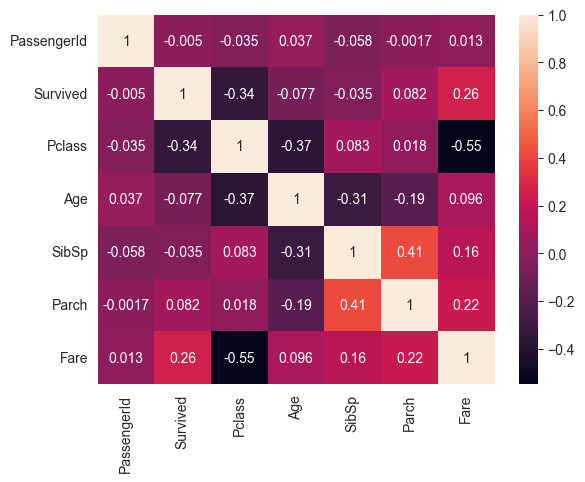

In [6]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

Unes quantes observacions (comentarem la correlació només a una de les dues variables):

- `PassengerId`: aquesta no té correlació significant amb cap dels altres atributs (com és d'esperar)
- `Survived`: obté la seva màxima correlació (inversament) amb `Pclass` i `Fare`: com més gran la classe, més petita la probabilitat de supervivència, i com més car el tiquet, més probabilitat
- `Pclass`: correlació inversa amb el preu del tiquet (està clar) i també amb l'edat, és dir els més joves es trobaven a classes més altes
- `Age`: relació inversa amb el nombre de germans/parelles i pares/fills, com més joves més germans/parelles i pares/fills
- `SibSp`: correlació amb el nombre de pares/fills, com més fills/parelles, més pares/fills
- `Parch`: correlació molt petita amb el preu del tiquet

Estudiem ara la distribució de les dades amb histogrames per cada atribut numèric (afegim les columnes `Embarked` i `Sex` al gràfic).

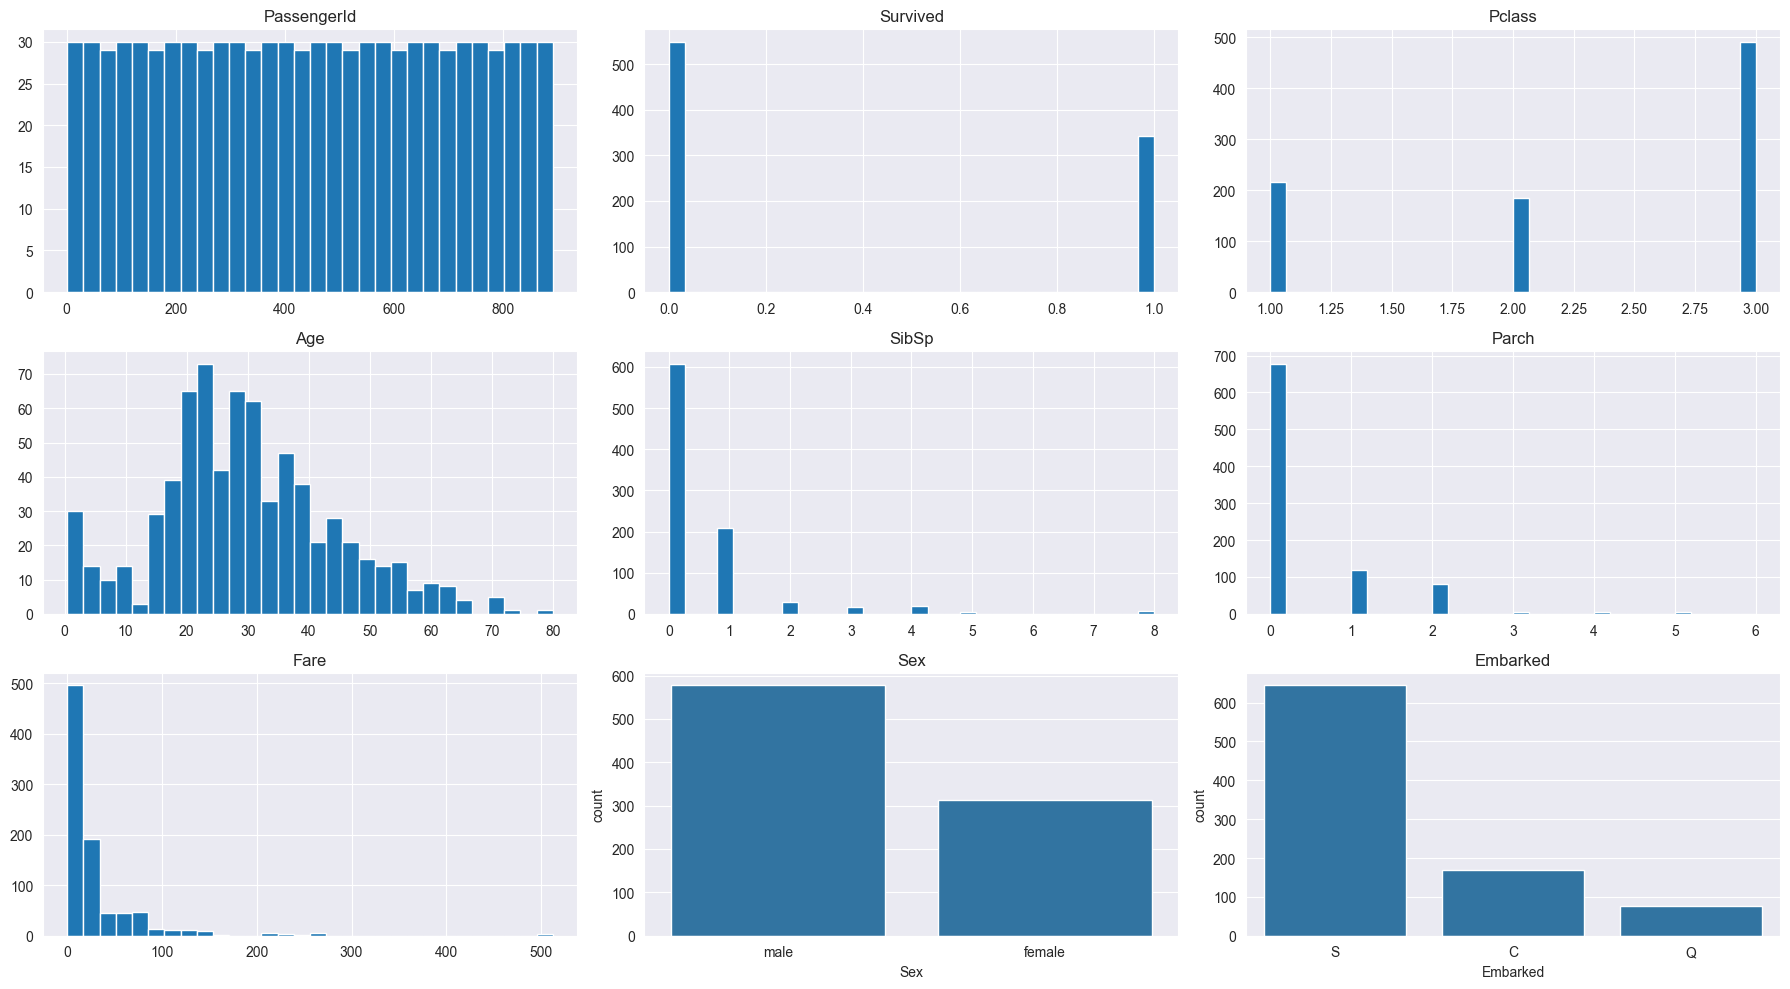

In [7]:
cols = list(df.select_dtypes("number")) + ["Sex", "Embarked"]
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if df[col].dtype == "object":
        sns.countplot(x=col, data=df, ax=ax)
    else:
        df[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Veiem que la distribució de l'edat té forma bastant normal (la distribució), amb una petita acumulació a edats petites. Les dues variables quantitatives enteres (`SibSp` i `Parch`) tenen més representació per a nombres petits.

Mirem amb més detall les distribucions de les altres columnes.

In [8]:
for col in ["Survived", "Pclass", "Sex", "Embarked"]:
    print(f"{col}:\n\t- {"\n\t- ".join([f"{key}: {value:.2%}" for key, value in dict(df[col].value_counts(normalize=True)).items()])}")

Survived:
	- 0: 61.62%
	- 1: 38.38%
Pclass:
	- 3: 55.11%
	- 1: 24.24%
	- 2: 20.65%
Sex:
	- male: 64.76%
	- female: 35.24%
Embarked:
	- S: 72.44%
	- C: 18.90%
	- Q: 8.66%


Tenim representació prou bona per totes les etiquetes, només pel port Queenstown una mica menys, però no és res greu.

Ara per ara, creiem que la distribució de les dades no influirà molt en la predicció de les dades, i que no donarà problemes. Faltaria fer una selecció, normalització i processament dels atributs per acabar de concloure si la distribució ens afectarà la predicció final, que és el que farem a la següent secció.

### 2. Preprocessing (normalitzation, outlier removal, feature selection, ...) (2 punts)
Un cop vistes les dades de les que es disposa, cal preparar les dades per als nostres algoritmes. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics, normalitzar les dades, treure outliers...

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estan les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització serà més adient per a les vostres dades?
* Teniu gaires dades sense informació (nans)? Tingueu en compte que hi ha metodes que no els toleren durant l'aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categòriques? Quina seria la codificació amb més sentit?
* Podreu treure algun atribut extra de les categòriques (per exemple, aplicant alguna regla sobre el text)?
* Caldria aplicar PCA? Quins beneficis o inconvenients trobarieu?
* Caldria aplicar alguna tècnica de selecció de variables? Ho trobeu necessari?

Llibreries que farem servir en aquesta secció.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

A partir de les conclusions extretes de la secció anterior, comencem a fer el preprocessing de tot el dataset. Ja hem vist que tenim moltes dades que falten, sobretot en el cas de l'edat i la cabina.

In [10]:
nan_count = df.isna().sum()
nan_percent = (nan_count / len(df)) * 100
nan_info = pd.DataFrame({
    "NaN Count": nan_count,
    "NaN Percent": nan_percent
})

nan_info[nan_info["NaN Count"] > 0]

,NaN Count,NaN Percent
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467


Començant per la cabina: veiem que falta una quantitat de dades molt gran, quasi el 80%. Per tant, seria molt complicat i gens significatiu aplicar qualsevol tipus d'imputació sobre aquesta columna. També observem que és una dada molt rellevant per la supervivència dels passatgers. Si busquem un esquema del Titanic, podem veure que els decks estan organitzats de la següent manera:

<div>
<img src="titanic/decks.png" width="500"/>
</div>

Per tant, com podem veure les cabines que son del deck G estan a baix de tot del vaixell, i les de l'A son les de més amunt. Creiem que el deck és una dada molt important per predir la supervivència, per tant, l'extraiem a partir del codi de cabina. Veiem que els codis son el deck més un nombre de cabina, sobre el qual no hem pogut trobar més informació.

Mirem els decks que surten a la base de dades.

In [11]:
sorted(df.loc[df["Cabin"].notna(), "Cabin"].str[0].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

Tenim cabines de tots els decks, i del `T`. Investiguem quantes cabines hi ha del deck `T`, que no sabem on és.b

In [12]:
df[df["Cabin"].str.contains("T", na=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


Com només és un passatger, considerem que és un error, per tant, marcarem el deck d'aquest passatger com un NaN. Amb totes les altres cabines que falten, marcarem els decks de totes amb la lletra `X` per distingir-les de les cabines normals.

Volem poder generalitzar aquest preprocessing a qualsevol dataset, per tant, creem una funció personalitzada que faci aquesta anàlisi de la cabina i la creï la nova columna `Deck` en forma d'un transformer.

In [13]:
def extract_deck(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Extreure la primera lletra de la cabina a una nova columna
    dataframe["Deck"] = dataframe["Cabin"].str[0]

    # Validar els decks existents
    valid_decks = {"A", "B", "C", "D", "E", "F", "G"}
    dataframe["Deck"] = dataframe["Deck"].where(dataframe["Deck"].isin(valid_decks), "X")

    # Omplir els forats amb "X"
    dataframe["Deck"] = dataframe["Deck"].fillna("X")

    return dataframe

# Crear un transformer
extract_deck_transformer = FunctionTransformer(extract_deck, validate=False)

Podem provar el pipeline fet amb el dataframe que tenim, aplicant-li només aquesta transofrmació.

In [14]:
extract_deck_transformer.transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,X
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,X
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,X
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C


Veiem que tenim una columna extra: `Deck`.

A part d'això, també considerem que és important saber simplement si tenim informació sobre la cabina, observem les proporcions de cabines que falten en funció de la classe.

In [15]:
df.groupby("Pclass")["Cabin"].apply(lambda x: x.isna().mean())

Pclass
1    0.185185
2    0.913043
3    0.975560
Name: Cabin, dtype: float64

Clarament, la majoria de cabines que tenim son de la classe 1. Per tant, com és una dada rellevant, afegim aquest indicador.

In [16]:
def indicate_missing_cabin(dataframe: pd.DataFrame, column: str = "Cabin") -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Crear una columna que indiqui si Cabin és available o no
    dataframe[column + "__missing"] = dataframe[column].isna().astype(int)

    return dataframe

# Crear un transformer
indicate_missing_cabin_transformer = FunctionTransformer(indicate_missing_cabin, validate=False)

I comprovem que funciona:

In [17]:
indicate_missing_cabin_transformer.transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin__missing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


Anem a estudiar ara la columna `Embarked`. Sabem que només hi ha dues files, anem a veure-les:b

In [18]:
df[df["Embarked"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Sabem que aquesta columna indica el port on ha pujat el passatger, per tant, podríem estimar a quin port ha pujat el passatger mirant els altres passatgers que han pagat un preu similar (òviament considerant la mateixa classe).

Per tant, mirem els passatgers amb la mateixa classe i preu similar, considerant més o menys 5 dòlars. Calculem la freqüència absoluta de cada port.

In [19]:
df[(df["Embarked"].notna()) & (df["Pclass"] == 1) & (75 <= df["Fare"]) & (df["Fare"] <= 85)]["Embarked"].value_counts()

Embarked
C    16
S    13
Name: count, dtype: int64

Veiem que aquests filtres inclouen 29 passatgers, dels quals 16 has pujat al port `C`, Cherbourg.

Sembla raonable considerar aquest mini-algoritme per determinar el port d'embarcació més probable. Implementem-lo amb una funció transformer com abans.

In [20]:
def impute_embarked(dataframe: pd.DataFrame, tolerance: float = 10.0) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    for idx, row in dataframe[dataframe["Embarked"].isna()].iterrows():
        pclass = row["Pclass"]
        fare = row["Fare"]

        # Candidats: mateix Pclass, Fare amb tolerància de +-10
        candidates = df[
            (df["Pclass"] == pclass) &
            (df["Embarked"].notna()) &
            (df["Fare"] >= fare - 10) &
            (df["Fare"] <= fare + 10)
        ]

        # Si s'han trobat candidats
        if not candidates.empty:
            dataframe.at[idx, "Embarked"] = candidates["Embarked"].mode()[0]
        else:
            # Si no s'han trobat candidats, agafar la moda de tot el dataframe
            dataframe.at[idx, "Embarked"] = dataframe["Embarked"].mode()[0]

    return dataframe

# Crear un transformer
impute_embarked_transformer = FunctionTransformer(impute_embarked, validate=False)

Comprovem que funciona, veient que no hi ha cap dada amb el port d'embarcació no disponible.

In [21]:
impute_embarked_transformer.transform(df)["Embarked"].isna().sum()

np.int64(0)

Ara hem de tractar les edats que falten. Representen una cinquena part de les dades, per tant, intentarem imputar fent servir algun algoritme o relació que observem amb els altres atributs.

Fem una primera gràfica amb la quantitat de passatgers amb una certa edat separant les classes. En aquest cas, no ens interessa el valor absolut de la quantiat de gent, només la proporció entre cada classe, per tant, indiquem l'opció `fill` per obtenir un sentit de les proporcions per cada franja d'edat.

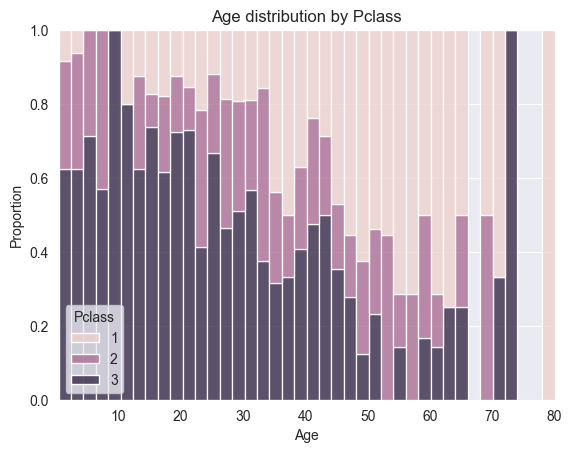

In [22]:
sns.histplot(
    data=df,
    x="Age",
    hue="Pclass",
    multiple="fill",
    bins=40
)

plt.xlabel("Age")
plt.ylabel("Proportion")
plt.title("Age distribution by Pclass")
plt.show()

Veiem que la classe 1 està centrada més a la dreta, i les classes 2 i 3 més a l'esquerra. Lo important d'aquesta gràfica és que les tres classes no tenen proporcions constants per totes les edats. Mirem ara les mitjanes d'edats per cada classe.

In [23]:
df.groupby("Pclass")["Age"].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Veiem que hi ha una diferència important d'edats entre les classes.

A partir d'aquesta informació, ja podríem calcular una mediana de les classes, i imputar aquest valor a cada passatger, però pensem que és massa brut fer-ho per una cinquena part del dataset, introduirà molta uniformitat i canviarà la distribució. Com ja hem vist amb el mapa de calor dels coeficients de correlació, l'edat tenia relació amb el nombre de germans/parelles i fills/pares, per tant, considerem que podem treure més informació de les dades que tenim per aconseguir una predicció més ajustada. Pensant en les noves columnes que hem afegit, creiem que podríem expandir les dades que tenim per aconseguir una predicció millor que només la moda. Mirem, per exemple, la distribució en funció de si es té informació de la cabina o no (per això, hem d'aplicar el transformer corresponent a la base de dades).

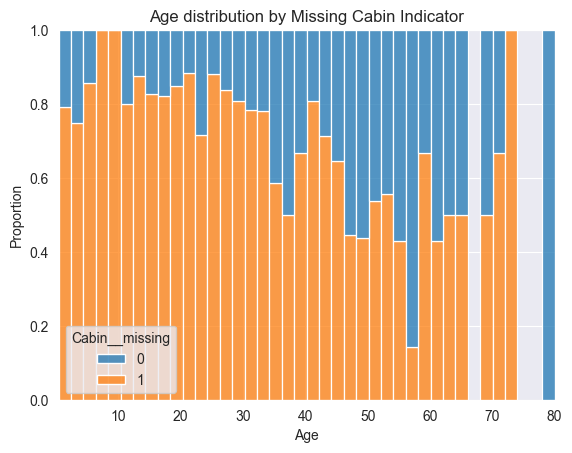

In [24]:
sns.histplot(
    data=indicate_missing_cabin_transformer.transform(df),
    x="Age",
    hue="Cabin__missing",
    multiple="fill",
    bins=40
)

plt.xlabel("Age")
plt.ylabel("Proportion")
plt.title("Age distribution by Missing Cabin Indicator")
plt.show()

A més, mirant les freqüències absolutes observem que també hi ha una gran diferència a la quantitat de gent en funció d'aquest indicador. En aquesta gràfica els dos grups (amb, i sense cabina indicada) estan superposats.

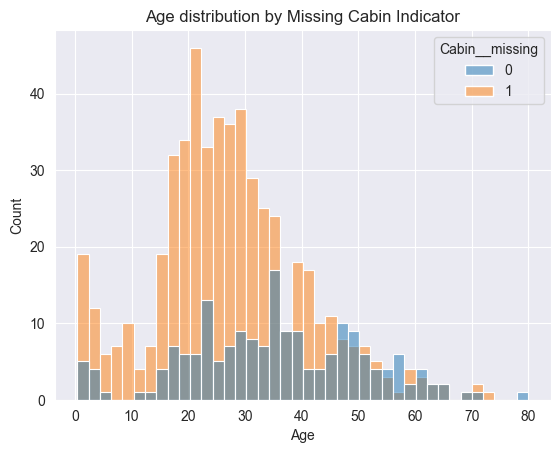

In [25]:
sns.histplot(
    data=indicate_missing_cabin_transformer.transform(df),
    x="Age",
    hue="Cabin__missing",
    bins=40
)

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution by Missing Cabin Indicator")
plt.show()

Mirem totes les columnes que tenim disponibles (considerant les transformacions ja fetes): `PassengerId`, `Survived`, `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, `Embarked`, `Deck`,`Cabin__missing`.

Fent un cop d'ull a la columna `Name`, veiem que hi ha noms que contenen tractaments, com "Mr.", "Mrs." i "Master.". Aquest podrien constituir un molt bon indicador de la seva edat, ja que, per exemple, master es fa servir per nens petits. Mirem tots els tractaments que apareixen (hem de fer servir la funció `extract` amb un regex per extreure el tractament abans del punt), i analitzem quants passatgers tenim per cada un amb, i sense edat.

In [26]:
df.groupby(df["Name"].str.extract(r"(\w+)\.", expand=False))["Age"].agg(
    WithAge=lambda x: x.notna().sum(),
    MissingAge=lambda x: x.isna().sum()
)

,WithAge,MissingAge
Name,,
Capt,1,0
Col,2,0
Countess,1,0
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,1,0
Major,2,0
Master,36,4


Veiem que hi ha molts títols que son el mateix escrit de dues formes, només apareixen per a una persona o son similars en significat, així que resumirem aquesta llista a unes categories més generals. Això ho farem en la funció transformer.

Tornem a l'anàlisi: agafem per exemple el títol "Master", i mirem la mitjana d'edat.

In [27]:
df[df["Name"].str.contains("Master.", regex=False)]["Age"].mean()

np.float64(4.574166666666667)

Clarament, pels passatgers amb títol master imputarem una edat semblant a aquesta, és dir molt petita.

Per poder treballar millor amb aquestes tractaments, creem un transformer que afegeixi aquesta columna a la nostra base de dades (fent el resum que comentàvem abans).

In [28]:
def extract_title(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Extreure el tractament i guardar-lo en una nova columna
    dataframe["Title"] = dataframe["Name"].str.extract(r"(\w+)\.", expand=False)

    return dataframe

# Crear un transformer
extract_title_transformer = FunctionTransformer(extract_title, validate=False)

Veiem que realment funciona.

In [29]:
extract_title_transformer.transform(df)["Title"].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

I que no té cap cel·la sense títol.

In [30]:
extract_title_transformer.transform(df)["Title"].isna().sum()

np.int64(0)

Pensant intuïtivament, és probable que com més gran sigui la familia de cada individu, més petita serà l'edad mitjana, considerant que la major part son nens. Per tant, proposem una nova columna agregada que, en aquest cas, és simplement la suma del nombre de germans/parelles i pares/fills. Com sempre, creem una funció per dur a terme aquesta transformació.

In [31]:
def add_family_size(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Extreure els membres de la familia (+1 per aquell passatger)
    dataframe["FamilySize"] = dataframe["SibSp"] + dataframe["Parch"] + 1

    return dataframe

# Crear un transformer
add_family_size_transformer = FunctionTransformer(add_family_size, validate=False)

Comprovem que funciona correctament.

In [32]:
add_family_size_transformer.transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


Comprovem ràpidament la nostra hipòtesi mirant només el coeficient de correlació de Pearson (que detecta relació de linealitat entre les dues variables).

In [33]:
df["Age"].corr(add_family_size_transformer.transform(df)["FamilySize"])

np.float64(-0.30191395919247593)

Dona negatiu, com esperàvem, és dir que a més membres en la familia, menor és l'edat. En valor absolut no és gaire convincent, es considera un valor baix, però de moment inclourem aquesta dada per fer la predicció de l'edat.

Amb totes les noves features que hem creat en la base de dades, ja podem pensar en com podem predir l'edat per a les persones que no en tenen una indicada. Estem en un cas ideal per fer servir l'algoritme KNN. Té sentit que si dos passatgers estan "a prop" en aquest espai multidimensional, tinguin edats similars. Per això, farem servir les variables categòriques títol i deck (que passarem a variables indicadores binàries), les numèriques preu, germans/parelles, pares/fills, membres de la familia i la binària que ens diu si té indicada una cabina.

Com aquest algoritme KNN és sensible a l'escala de les variables (ja que tracta amb distàncies), és necessari aplicar una normalització de les dades numèriques abans de començar el procés iteratiu.

Implementem tot això a través d'un pipeline que automàticament ens passa les categòriques a binàries, normalitza i prediu les edats (després d'incloure tots els transformers fets anteriorment).

In [34]:
categorical_features = ["Title", "Cabin__missing", "Pclass"]
numerical_features = ["Fare", "SibSp", "Parch", "FamilySize"]

age_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features),
        ("pred", "passthrough", ["Age"])
    ]
)

age_pipeline = Pipeline([
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("preprocessor", age_preprocessor),
    ("imputer", KNNImputer(n_neighbors=5))
])

Executem el pipeline i guardem el resultat final per fer unes observacions.

In [35]:
new_df = pd.DataFrame(age_pipeline.fit_transform(df), columns=age_pipeline.named_steps["preprocessor"].get_feature_names_out())
new_df.describe()

,cat__Title_Col,cat__Title_Countess,cat__Title_Don,cat__Title_Dr,cat__Title_Jonkheer,cat__Title_Lady,cat__Title_Major,cat__Title_Master,cat__Title_Miss,cat__Title_Mlle,...,cat__Title_Rev,cat__Title_Sir,cat__Cabin__missing_1,cat__Pclass_2,cat__Pclass_3,num__Fare,num__SibSp,num__Parch,num__FamilySize,pred__Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,0.002245,0.001122,0.001122,0.007856,0.001122,0.001122,0.002245,0.044893,0.204265,0.002245,...,0.006734,0.001122,0.771044,0.206510,0.551066,3.987333e-18,4.386066e-17,5.382900e-17,-2.392400e-17,29.655598
std,0.047351,0.033501,0.033501,0.088337,0.033501,0.033501,0.047351,0.207186,0.403390,0.047351,...,0.081830,0.033501,0.420397,0.405028,0.497665,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,13.892370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.484217e-01,-4.745452e-01,-4.736736e-01,-5.609748e-01,0.420000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,-4.891482e-01,-4.745452e-01,-4.736736e-01,-5.609748e-01,21.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,-3.573909e-01,-4.745452e-01,-4.736736e-01,-5.609748e-01,28.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,-2.424635e-02,4.327934e-01,-4.736736e-01,5.915988e-02,38.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.667167e+00,6.784163e+00,6.974147e+00,5.640372e+00,80.000000


Mirem, primer, que ara sí tinguem totes les dades sense NaN's (entre les columnes que hem fet servir en el preprocessador pel KNN, per exemple cabines segueix tenint NaN's).

In [36]:
new_df.isna().sum().sum()

np.int64(0)

Ara comparem les edats mitjanes per títol abans, i després de l'imputament amb el KNN.

In [37]:
df_titled = extract_title_transformer.transform(df)
df_titled["Imputed Age"] = new_df.iloc[:, -1]
age_comparison = pd.DataFrame({
    "Original_Age": df_titled.groupby("Title")["Age"].mean(),
    "Imputed_Age": df_titled.groupby("Title")["Imputed Age"].mean(),
})
age_comparison["NaN_Count"] = df_titled.groupby("Title")["Age"].apply(lambda x: x.isna().sum())
age_comparison["Difference"] = age_comparison["Imputed_Age"] - age_comparison["Original_Age"]

age_comparison

,Original_Age,Imputed_Age,NaN_Count,Difference
Title,,,,
Capt,70.000000,70.000000,0,0.000000
Col,58.000000,58.000000,0,0.000000
Countess,33.000000,33.000000,0,0.000000
Don,40.000000,40.000000,0,0.000000
Dr,42.000000,41.314286,1,-0.685714
Jonkheer,38.000000,38.000000,0,0.000000
Lady,48.000000,48.000000,0,0.000000
Major,48.500000,48.500000,0,0.000000
Master,4.574167,4.770950,4,0.196783


Podem observar que l'algoritme KNN ha estat molt fidel amb el que nosaltres esperàvem, que les edats siguin semblants pel mateix títol. Veiem que les mitjanes per honorífic han canviat molt poc.

Analitzem també les distribucions de les edats abans i després de l'imputament.

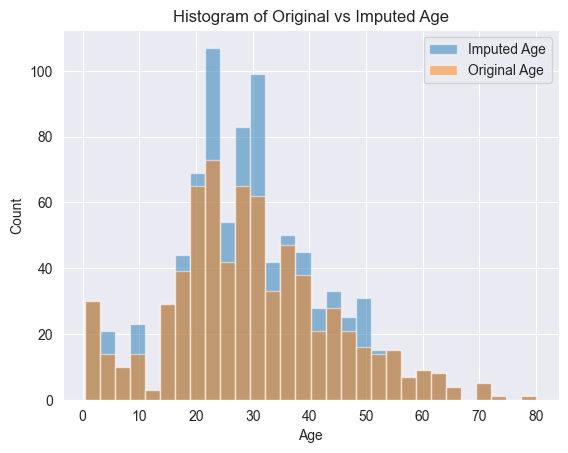

In [38]:
plt.hist(df_titled["Imputed Age"], bins=30, alpha=0.5, label="Imputed Age")
plt.hist(df_titled["Age"].dropna(), bins=30, alpha=0.5, label="Original Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Original vs Imputed Age")
plt.legend()
plt.show()

Observem que la distribució de les edats imputades segueix prou precisament la forma de les edats originals, per tant donarem aquests resultats per bons.

Amb aquesta última anàlisi, acabem de tractar totes les columnes amb informació mancant. Fem un repàs:

- `Cabin`: hem extret la columna `Deck` (`extract_deck_transformer`) i hem afegit un indicador `Cabin__missing` per saber si disposem de la dada (`indicate_missing_cabin_transformer`)
- `Embark`: hem extret els passatgers de la mateixa classe i preu semblant i hem agafat la moda (`impute_embarked_transformer`)
- `Age`: hem vist que `Pclass` i `Cabin__missing` son importants per predir l'edat, hem extret el títol del nom per crear `Title` (`extract_title_transformer`) i la mida de la família a partir dels germans/parelles i pares/fills per crear `FamilySize` (`add_family_size_transformer`), i amb totes aquestes dades hem fet un KNN per predir les edats que faltaven (`age_pipeline`)

Com més endavant voldrem enllaçar tots els transformers en una pipeline, millorem el transformer de predicció de l'edat. Ho farem creant una classe custom a partir de les classes base de sklearn, implementant les funcions base `fit` i `transform`.

In [39]:
class AgeKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.age_features = ["Fare", "SibSp", "Parch", "FamilySize", "Title", "Cabin__missing", "Pclass"]
        self.ohe = None
        self.scaler = None
        self.knn = None
        self.column_transformer = None
        self.feature_names_out_ = None

    @staticmethod
    def create_necessary_features(dataframe_x: pd.DataFrame) -> pd.DataFrame:
        # Crear les features que calen si no hi son
        if "FamilySize" not in dataframe_x.columns:
            dataframe_x = add_family_size_transformer.transform(dataframe_x)
        if "Title" not in dataframe_x.columns:
            dataframe_x = extract_title_transformer.transform(dataframe_x)
        if "Cabin__missing" not in dataframe_x.columns:
            dataframe_x = indicate_missing_cabin_transformer.transform(dataframe_x)

        return dataframe_x

    def fit(self, dataframe_x, y=None):
        # Copiar el dataframe
        dataframe_x = dataframe_x.copy()

        # Crear les features que no existeixen
        dataframe_x = self.create_necessary_features(dataframe_x)

        # Features
        cat_fts = ["Title", "Cabin__missing", "Pclass"]
        num_fts = ["Fare", "SibSp", "Parch", "FamilySize"]

        # Transformadors
        self.column_transformer = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_fts),
                ("num", StandardScaler(), num_fts),
                ("pred", "passthrough", ["Age"])
            ]
        )

        # Fit dels transformadors
        self.column_transformer.fit(dataframe_x)

        # Fit KNNImputer
        transformed = self.column_transformer.transform(dataframe_x)
        self.knn = KNNImputer(n_neighbors=self.n_neighbors)
        self.knn.fit(transformed)

        # Guardar els noms de les columnes
        cat_features_out = self.column_transformer.named_transformers_["cat"].get_feature_names_out(categorical_features)
        self.feature_names_out_ = np.concatenate([cat_features_out, numerical_features, ["Age"]])

        return self

    def transform(self, dataframe_x):
        # Copiar el datagram
        dataframe_x = dataframe_x.copy()
        
        # Crear les features que no existeixen
        dataframe_x = self.create_necessary_features(dataframe_x)

        # Predir l'edat
        transformed = self.column_transformer.transform(dataframe_x)
        imputed = self.knn.transform(transformed)

        # Copiar els resultats
        result = dataframe_x.copy()
        result["Age"] = imputed[:, -1]

        return result

Provem si funciona la classe igual que abans.

In [40]:
age_knn_processor = AgeKNNImputer(n_neighbors=5)
age_knn_processor.fit(df)
new_df = age_knn_processor.transform(df)
new_df.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
FamilySize          0
Title               0
Cabin__missing      0
dtype: int64

Veiem que retorna les mateixes columnes (els mateixos noms) més totes les auxiliars que es necessiten per fer la predicció. També observem que efectivament no queden valors nul·ls a la columna de les edats.

**IMPORTANT**: encara no hem encadenat tots els transformadors, és normal que tinguem embarked i cabines NaN's, en cap moment li hem aplicat el transformador corresponent per treure-les, al final de la secció farem un pipeline general amb totes les funcions.

En aquest moment ja tenim transformadors per aprofitar al màxim la informació de totes les columnes.

De la columna `Title` recordem que tenim moltes categories, de les quals la majoria son per a només poques persones. Com després haurem de passar aquesta variable a indicadors binaris, no volem tenir la meitat de features que siguin indicadors del títol, per tant, reduïm les categories d'aquesta variable a només unes quantes.

In [41]:
def compress_title(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Diccionari de categories
    mapping = {
        "Capt": "Military", "Col": "Military", "Major": "Military",
        "Don": "Nobility", "Dona": "Nobility", "Jonkheer": "Nobility",
        "Lady": "Nobility", "Sir": "Nobility", "Countess": "Nobility",
        "Master": "Nobility", "Miss": "Ms", "Mlle": "Ms", "Ms": "Ms",
        "Mrs": "Mrs", "Mme": "Mrs"
    }

    # Fer el mapeig
    dataframe["Title"] = dataframe["Title"].map(mapping).fillna(dataframe["Title"])

    return dataframe

compress_title_transformer = FunctionTransformer(compress_title, validate=False)

Veiem que funciona.

In [42]:
compress_title_transformer.transform(extract_title_transformer.transform(df))["Title"].value_counts()

Title
Mr          517
Ms          185
Mrs         126
Nobility     45
Dr            7
Rev           6
Military      5
Name: count, dtype: int64

De la columna del tiquet no hem pogut trobar ni extreure cap informació valuosa per la predicció, així que decidim esborrar-la.

Tornem ara a les distribucions de les dades numèriques i categòriques per decidir si tenim outliers o si caldria limitar el domini de cada atribut. Ho fem només ara perquè ara sí que tenim totes les dades que necessitem (sobretot, les edats), i també hem de considerar la columna creada `FamilySize`. La columna `Pclass` no la tindrem en compte perquè ja hem vist que està equilibrada i no hi ha valors extrems.

Creem un pipeline ràpid per afegir les columnes que falten i imputar les edats.

In [43]:
temp_preprocessor = Pipeline(steps=[
    ("extract_deck", extract_deck_transformer),
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("impute_embarked", impute_embarked_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("impute_age", AgeKNNImputer()),
    ("compress_title", compress_title_transformer),
])

temp_df = temp_preprocessor.fit_transform(df)

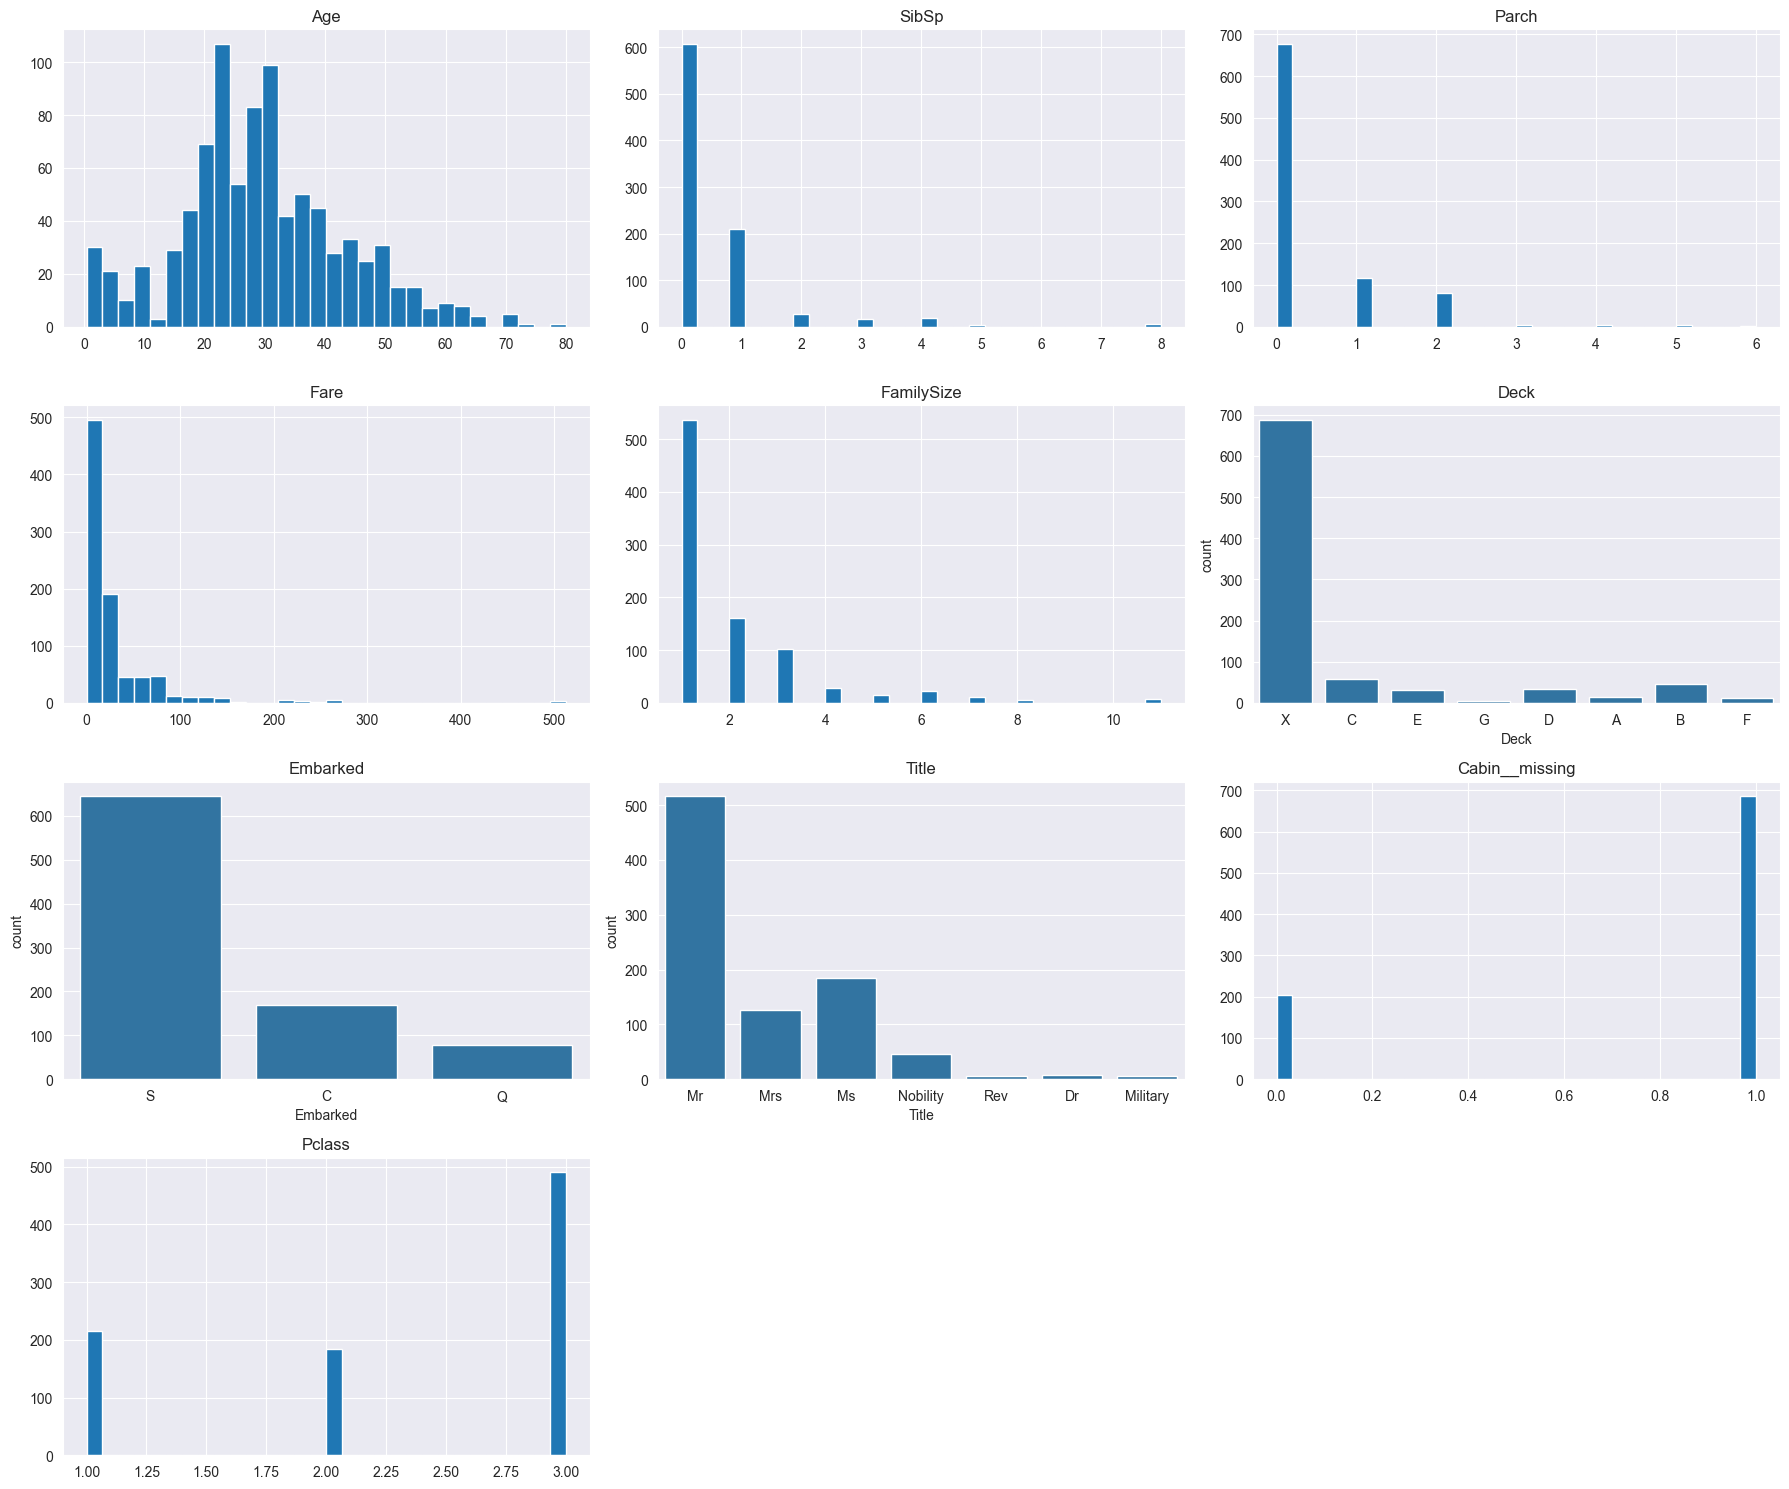

In [44]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Deck", "Embarked", "Title", "Cabin__missing", "Pclass"]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if temp_df[col].dtype == "object":
        sns.countplot(x=col, data=temp_df, ax=ax)
    else:
        temp_df[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

La idea és trobar els valors "outlier", o atípics. Podem aconseguir això mirant l'interval interquartílic. Creem un transformador que ens retalli les variables numèriques a 1.5 cops aquest interval i veiem els resultats.

In [45]:
class IQRTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.select_dtypes(include=[np.number]).columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - self.factor * iqr
            upper = q3 + self.factor * iqr
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X.columns:
                X[col] = X[col].clip(lower=lower, upper=upper)
        return X

trimmer = IQRTrimmer()
temp_df_trimmed = trimmer.fit_transform(temp_df)

Repetim les gràfiques amb el nou dataframe.

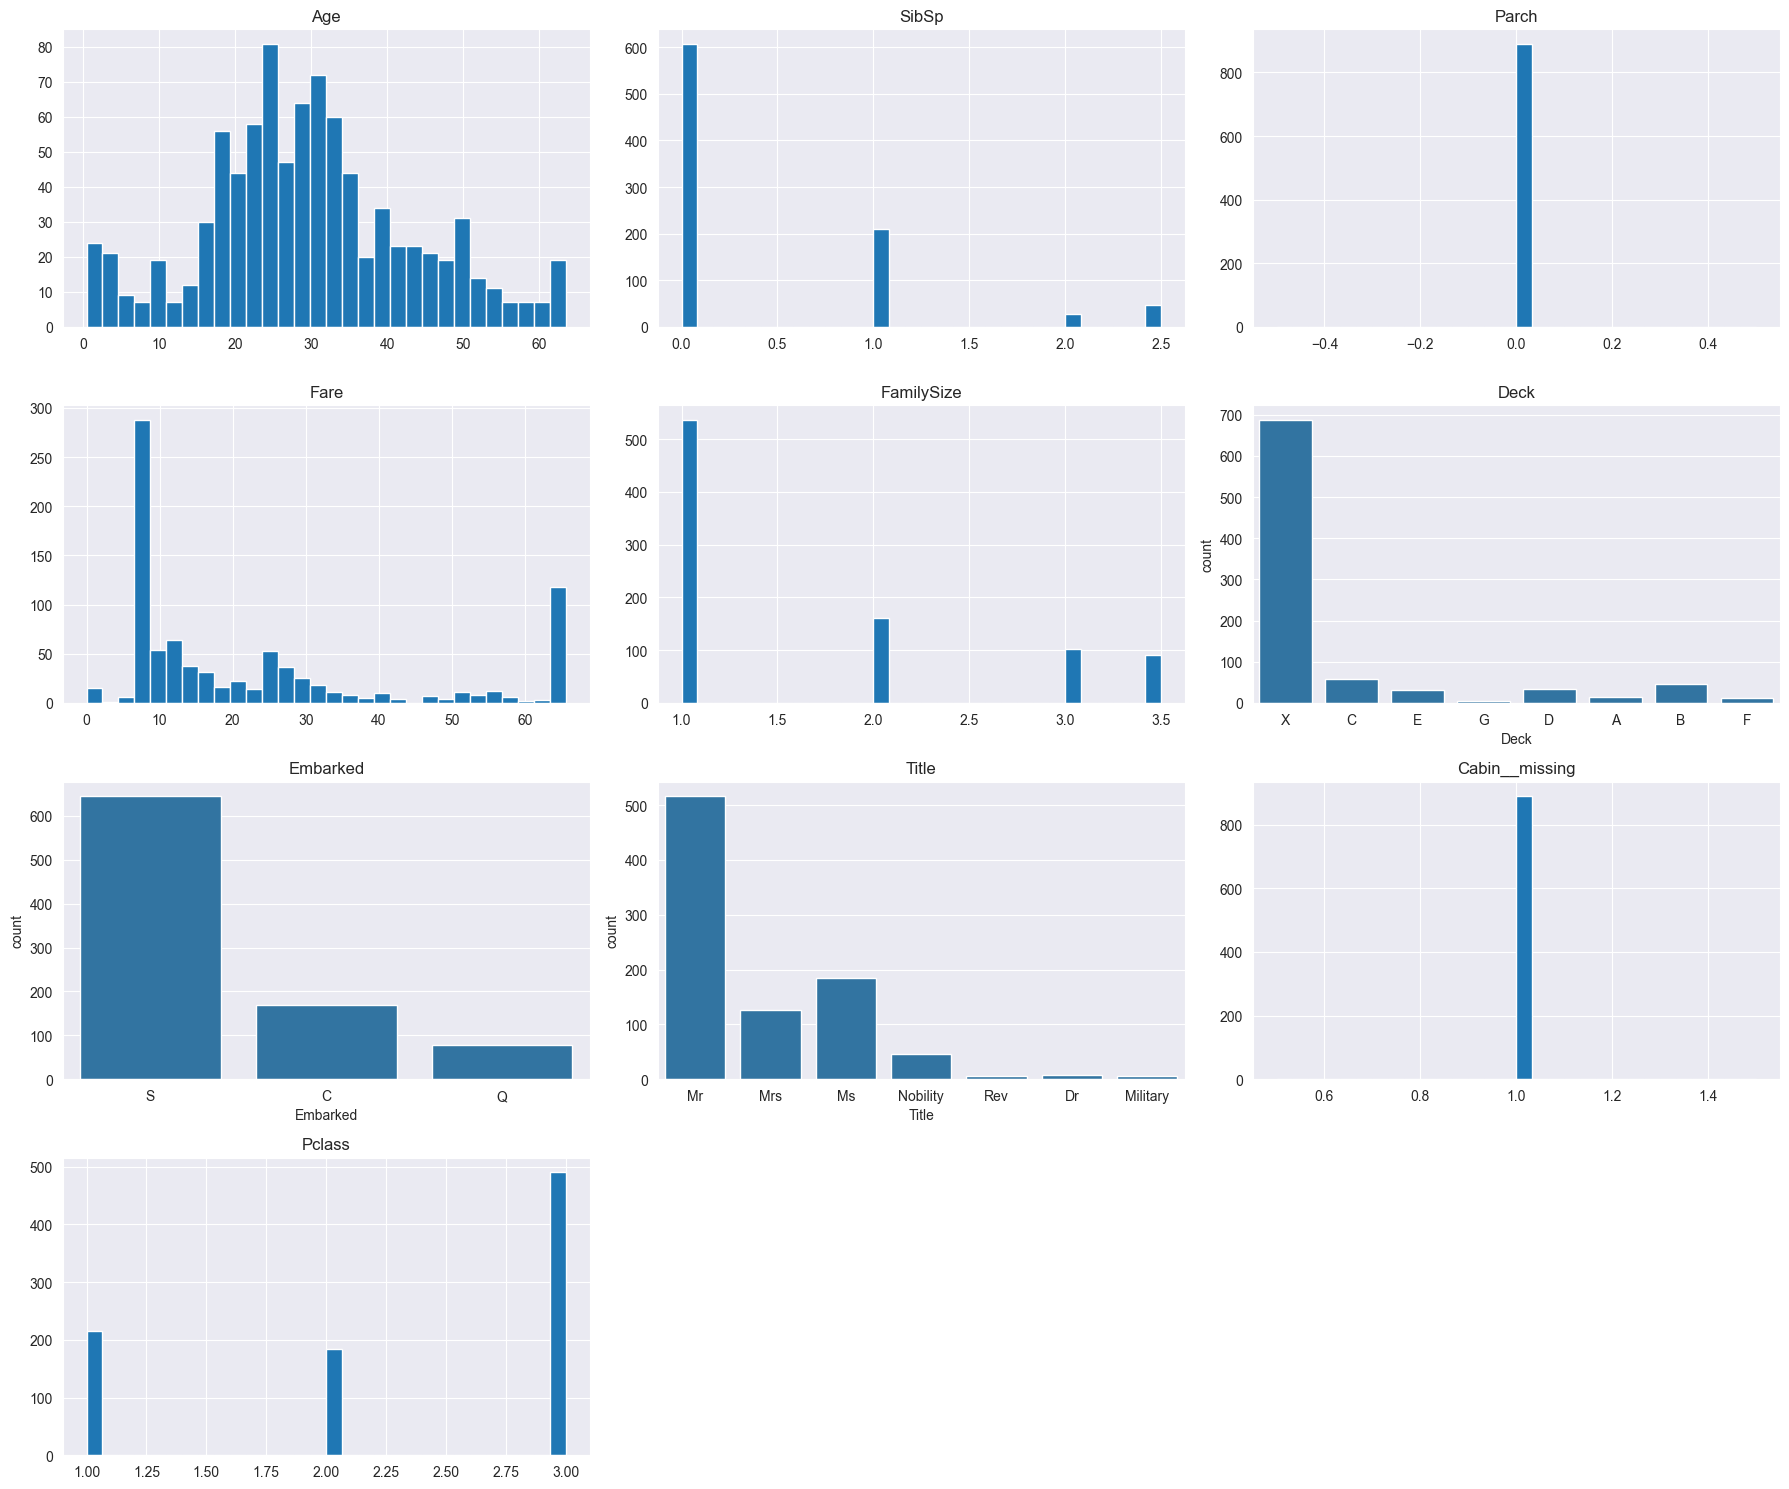

In [46]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Deck", "Embarked", "Title", "Cabin__missing", "Pclass"]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if temp_df_trimmed[col].dtype == "object":
        sns.countplot(x=col, data=temp_df_trimmed, ax=ax)
    else:
        temp_df_trimmed[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Veiem que els resultats no son els esperats. De la columna `Cabin__missing` no volem perdre tota la informació que tenim (que seria posar que tots tenen cabin), per tant, per cada columna farem un tractament diferent:

- `Age`: agafarem un threshold aproximat de 65
- `Parch` i `SibSp`: limitarem a 0, 1 o 2 (considerant 2 com 2 o més)
- `FamilySize`: limitarem a 1, 2, 3 i 4 (considerant 4 com 4 o més)
- `Fare`: limitarem al preu aproximate de 100

Deixarem les altres variables com estan.

In [47]:
def custom_threshold(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Age: threshold a 65
    if "Age" in dataframe.columns:
        dataframe["Age"] = np.where(dataframe["Age"] > 65, 65, dataframe["Age"])

    # Parch i SibSp: màxim 2
    for col in ["Parch", "SibSp"]:
        if col in dataframe.columns:
            dataframe[col] = np.where(dataframe[col] > 2, 2, dataframe[col])

    # FamilySize: màxim 4
    if "FamilySize" in dataframe.columns:
        dataframe["FamilySize"] = np.where(dataframe["FamilySize"] > 4, 4, dataframe["FamilySize"])

    # Fare: threshold a 100
    if "Fare" in dataframe.columns:
        dataframe["Fare"] = np.where(dataframe["Fare"] > 100, 100, dataframe["Fare"])

    return dataframe

custom_threshold_transformer = FunctionTransformer(custom_threshold, validate=False)
temp_df_threshold = custom_threshold_transformer.transform(temp_df)

Analitzem les noves distribucions.

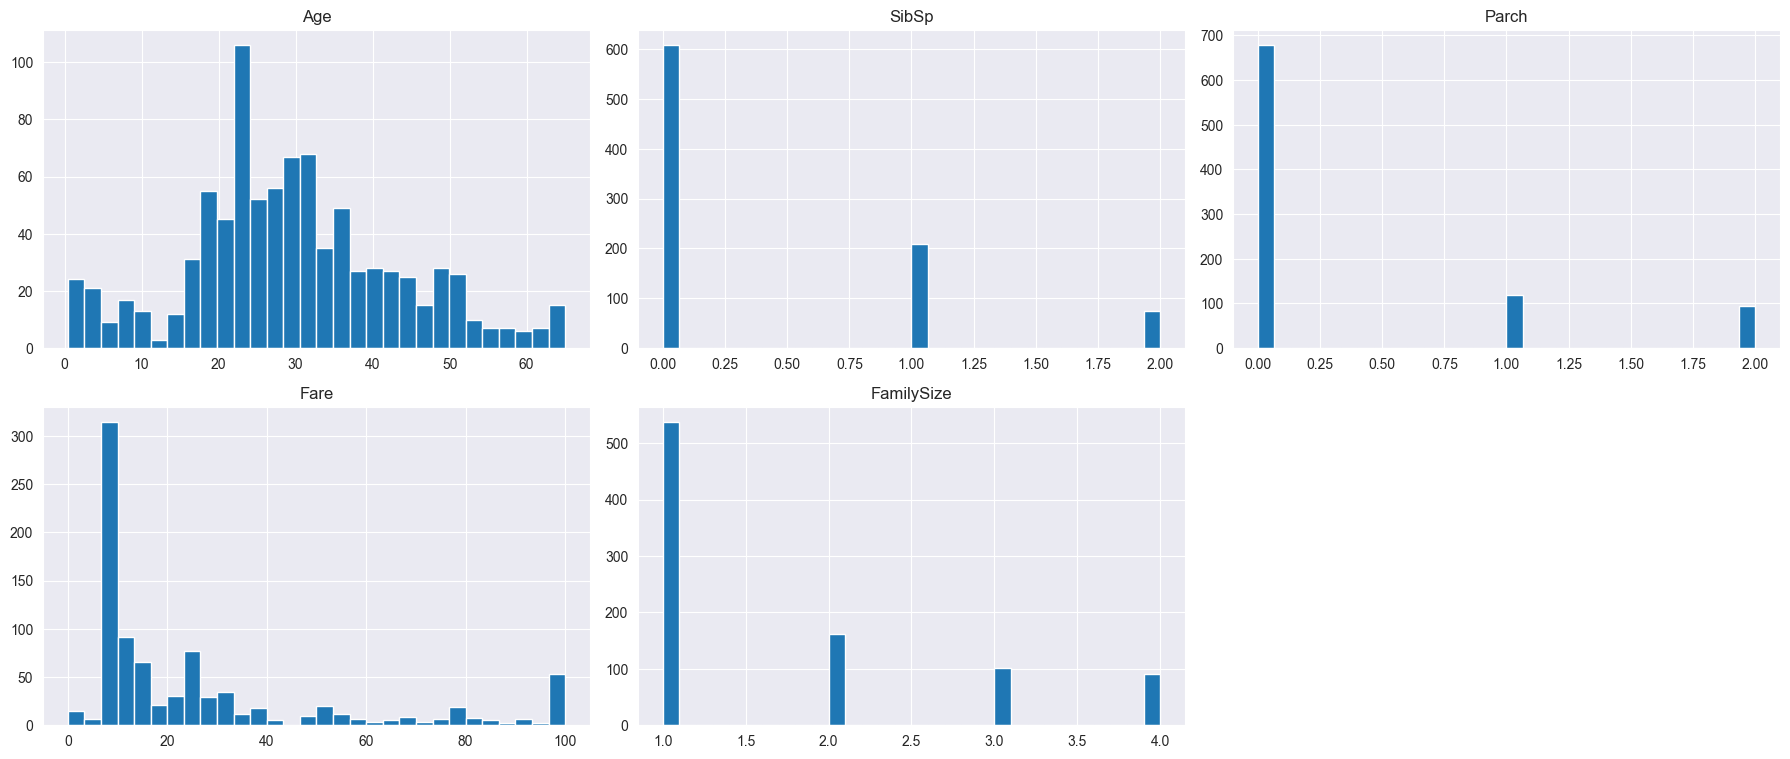

In [48]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize"]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if temp_df_threshold[col].dtype == "object":
        sns.countplot(x=col, data=temp_df_threshold, ax=ax)
    else:
        temp_df_threshold[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Considerem que les noves distribucions tenen sentit, així que les deixarem per la versió final del dataframe.

Els models d'aprenentatge que farem servir només entenen atributs numèrics, així que ens hem de desfer dels que no ho son. Els categòrics (`Sex`, `Embarked`, `Title`, `Deck`) els podrem passar a binaris (també s'accepten com a 0 o 1), així que aquests els deixem. De la columna `Name` ja no en traurem més profit a part del `Title`, així que decidim esborrar aquesta columna del dataset final. Passa igual amb la cabina, ja li hem extret el `Deck` i no podem fer servir cap més informació a part d'aquesta, la decidim esborrar també.

In [49]:
def normalize_numerics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    num_cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Pclass"]
    df_num = df[num_cols].copy()
    for col in num_cols:
        mean = df_num[col].mean()
        std = df_num[col].std()
        df_num[col] = (df_num[col] - mean) / std if std != 0 else 0
    other_cols = df.drop(columns=num_cols)
    df_final = pd.concat([df_num, other_cols], axis=1)
    return df_final

normalize_numerics_transformer = FunctionTransformer(normalize_numerics, validate=False)
normalized_df = normalize_numerics_transformer.fit_transform(temp_df_threshold)

def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    cat_cols = ["Sex", "Embarked", "Deck", "Title"]
    df_encoded = pd.get_dummies(df[cat_cols], drop_first=True, dummy_na=False)
    other_cols = df.drop(columns=cat_cols)
    df_final = pd.concat([df_encoded, other_cols], axis=1)
    return df_final

encode_categoricals_transformer = FunctionTransformer(encode_categoricals, validate=False)
encoded_df = encode_categoricals_transformer.fit_transform(normalized_df)

Podem observar les dades normalitzades.

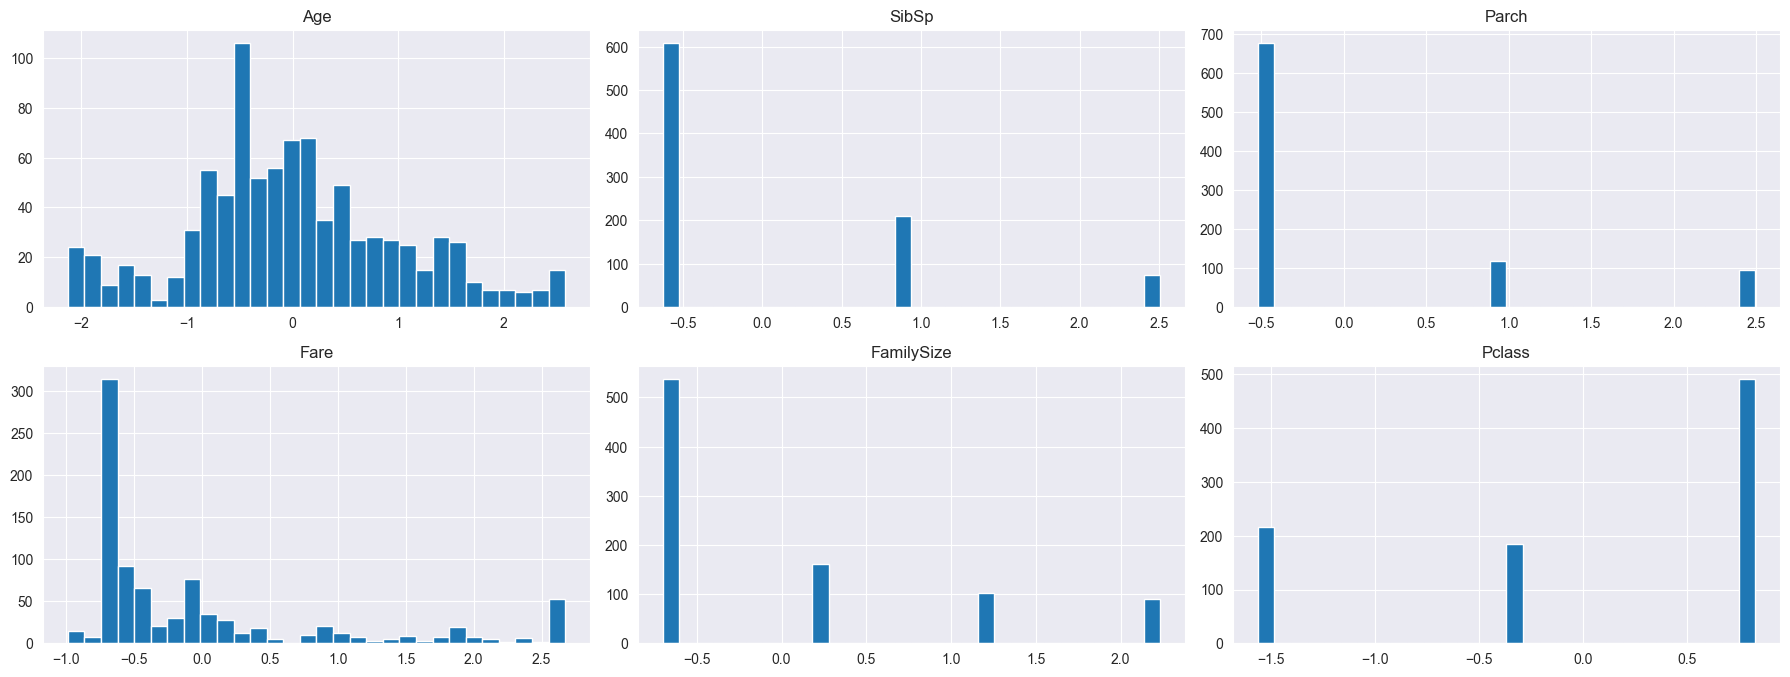

In [50]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Pclass"]
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if normalized_df[col].dtype == "object":
        sns.countplot(x=col, data=normalized_df, ax=ax)
    else:
        normalized_df[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Fem un transformer ràpid per eliminar les columnes.

In [51]:
def drop_column(dataframe, columns):
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Esborrar les columnes
    return dataframe.drop(columns=columns, errors="ignore")

drop_cols = {"columns": ["Name", "Cabin", "Ticket"]}

drop_transformer = FunctionTransformer(drop_column, kw_args=drop_cols, validate=False)

Finalment, construïm el pipeline final amb totes les implementacions que hem fet.

In [52]:
preprocessor = Pipeline(steps=[
    ("extract_deck", extract_deck_transformer),
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("impute_embarked", impute_embarked_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("impute_age", AgeKNNImputer()),
    ("compress_title", compress_title_transformer),
    ("custom_threshold", custom_threshold_transformer),
    ("normalize", normalize_numerics_transformer),
    ("encode", encode_categoricals_transformer),
    ("drop", drop_transformer),
])

Apliquem aquest pipeline al dataframe per comprovar que funciona correctament.

In [53]:
processed_df = preprocessor.fit_transform(df)
display(processed_df)
display(processed_df.columns)

,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X,...,Title_Rev,Age,SibSp,Parch,Fare,FamilySize,Pclass,PassengerId,Survived,Cabin__missing
0,True,False,True,False,False,False,False,False,False,True,...,False,-0.553590,0.939785,-0.521177,-0.724528,0.277604,0.826913,1,0,1
1,False,False,False,False,True,False,False,False,False,False,...,False,0.612373,0.939785,-0.521177,1.621304,0.277604,-1.565228,2,1,0
2,False,False,True,False,False,False,False,False,False,True,...,False,-0.262099,-0.628283,-0.521177,-0.699799,-0.700045,0.826913,3,1,1
3,False,False,True,False,True,False,False,False,False,False,...,False,0.393755,0.939785,-0.521177,0.955167,0.277604,-1.565228,4,1,0
4,True,False,True,False,False,False,False,False,False,True,...,False,0.393755,-0.628283,-0.521177,-0.695220,-0.700045,0.826913,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,True,False,True,False,False,False,False,False,False,True,...,True,-0.189227,-0.628283,-0.521177,-0.513879,-0.700045,-0.369158,887,0,1
887,False,False,True,True,False,False,False,False,False,False,...,False,-0.772208,-0.628283,-0.521177,0.108908,-0.700045,-1.565228,888,1,0
888,False,False,True,False,False,False,False,False,False,True,...,False,-1.500936,0.939785,2.494203,-0.131048,2.232901,0.826913,889,0,1
889,True,False,False,False,True,False,False,False,False,False,...,False,-0.262099,-0.628283,-0.521177,0.108908,-0.700045,-1.565228,890,1,0


Index(['Sex_male', 'Embarked_Q', 'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_X', 'Title_Military', 'Title_Mr',
       'Title_Mrs', 'Title_Ms', 'Title_Nobility', 'Title_Rev', 'Age', 'SibSp',
       'Parch', 'Fare', 'FamilySize', 'Pclass', 'PassengerId', 'Survived',
       'Cabin__missing'],
      dtype='object')

I no obtenim cap cel·la sense valors.

In [54]:
processed_df.isna().sum().sum()

np.int64(0)

Per acabar aquesta secció comentarem dues coses importants: PCA i normalització.

La primera: Primary Component Analysis. La utilitat principal d'aquest mètode és reduir la dimensionalitat d'un problema si aquest és molt gran o si pensem que hi ha dimensions que no aporten informació a la predicció. En el nostre cas, no es dona cap de les situacions. La dimensió és relativament petita, i a priori pensem que totes les variables son importants. A més, tenim una explicació molt fàcil i interpretació directa a partir de les quantitats. Aplicar PCA es carregaria aquesta interpretabilitat, potser augmentant lleugerament el temps de còmput (un cop entrenat), però perdrem un gran part del problema que és la interpretació de les dades, bàsicament el treball que hem estat fent en aquestes dues seccions.

La segona: Normalització. Quan estem treballant amb algoritmes que fan servir distàncies, és normal aplicar una normalització a tots els atributs per així no donar prioritat a les magnituds que potser simplement estan en una altra escala. Per evitar això, normalment s'agafen totes les dades i se les aplica una transformació lineal per centrar-les al zero i amb variació 1. Aquesta és la Standard, la més normal. També hi ha la MinMax, que porta tot el rang de valor a un altre interval desitjat. Com estem treballant amb pipelines i ja tenim funcions implementades per fer aquestes normalitzacions, és molt fàcil afegir o treure-les quan vulguem. Sabem que per alguns mètodes està bé conservar la magnitud (en general és igual), així que, de moment, deixarem les dades amb les magnituds reals i després, per cada model, afegirem una línia que aplicarà la normalització abans.

### 3. Metric selection (1.5 punts)
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). Per a fer-ho, entreneu una regressio logistica i a partir d'aquesta generarem una serie de funcions per analitzar els nostres resultats. Aquestes funcions ens serviran més endavant. Caldrà tambe triar la mètrica que farem servir després per triar el millor model.

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`?
* Abans de començar a entrenar models, genereu una suite de funcions per poder analitzar graficament com esta anant el vostre model. Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset?
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina mètrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

**Nota**: Fixeu-vos que en aquest apartat NO ES VALOREN ELS RESULTATS. L'únic que es valora és l'elecció de la mètrica de classificació així com saber quin tipus de gràfiques fer per analitzar els resultats. Abans de solucionar un problema cal tenir molt clar la mètrica d'error que es farà servir, i és una decisió que cal pendre de forma prèvia a entrenar models.

- Accuracy: Percentatge de prediccions correctes sobre el total.
- Precision: Proporció de prediccions positives que són realment positives (TP / (TP + FP)).
- Recall (True Positive Rate, TPR): Proporció de positius reals que el model detecta respecte a la realitat de positius (TP / (TP + FN)).
- F1-score: Mitjana harmònica entre precision i recall (equilibri).
- Precision-Recall Curve: Gràfic que mostra com canvien precision i recall segons el llindar.
    - Eixos: X = Recall, Y = Precision
    - Mostra trade-off entre detectar positius i evitar falsos positius.
    - Cada punt = un llindar diferent.
    - Molt útil amb classes desequilibrades.
    - Àrea sota corba = Average Precision (AP)
- ROC Curve: Gràfic de True Positive Rate (Recall) vs False Positive Rate a diferents llindars, per cada llindar, es calcula TPR i FPR.
    - Eixos: X = FPR (False Positive Rate), Y = TPR (Recall)
    - Mostra com canvia TPR respecte a FPR segons el llindar.
    - Cada punt = un llindar diferent.
    - Útil amb classes equilibrades.
    - Àrea sota corba = ROC-AUC (mesura la capacitat de separar positives i negatives).
- Threshold en la gràfica: Valor de decisió per classificar una mostra com positiva si la probabilitat estimada és superior o igual a aquest llindar, així havent-hi a la gràfica tants punts com thresholds. Per tant, si tinguéssim una mica menys de probabilitat, per aquell threshold, la mostra es classificaria com negativa. I fixat si fixéssim el threshold una mica menor, obtindríem un punt diferent de la gràfica associat a aquest nou threshold.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

In [56]:
X = processed_df[[col for col in processed_df.columns if col != "Survived"]]
y = processed_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Prediccions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"\nResultats amb el model base:")
print(f"   • Accuracy Score:          {accuracy:.4f}")
print(f"   • F1 Score:                {f1:.4f}")
print(f"   • Average Precision Score: {avg_precision:.4f}")

print(classification_report(y_test, y_pred))


Resultats amb el model base:
   • Accuracy Score:          0.7989
   • F1 Score:                0.7500
   • Average Precision Score: 0.7924
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       106
           1       0.76      0.74      0.75        73

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



Amb el model entrenat, podem avaluar les mètriques en qüestió, però no podem escollir quines mètriques són més adequades sense conèixer la distribució de les classes en el dataset, i què es vol prioritzar.

In [57]:
class_distribution = y.value_counts(normalize=True)
majority_class = class_distribution.max()
minority_class = class_distribution.min()
imbalance_ratio = majority_class / minority_class

print(f"Distribució de classes:")
print(f"   Classe 0 (No sobreviu): {class_distribution[0]:.2%}")
print(f"   Classe 1 (Sobreviu):    {class_distribution[1]:.2%}")
print(f"\nRàtio de desequilibri: {imbalance_ratio:.2f}:1")

Distribució de classes:
   Classe 0 (No sobreviu): 61.62%
   Classe 1 (Sobreviu):    38.38%

Ràtio de desequilibri: 1.61:1


Amb un ràtio de 1.61:1, el dataset NO està severament desequilibrat, però SÍ té un biaix cap a la classe majoritària (No sobreviu, 0). Això afectarà la selecció de mètriques de la següent manera:

1. Accuracy: Pot ser enganyosa en datasets desequilibrats.
   Al Titanic, encara que no és extremadament desequilibrat, hi ha més morts que supervivents.
   Així que un model que prediu gairebé sempre "mor" tindria bona accuracy, però seria inútil per detectar els supervivents. Per això no l'hem triada.

2. Precision i Recall: Són més informatives per avaluar el rendiment en la classe minoritària ("Sobreviu", 1).
   - Precision mira quants dels supervivents predits realment sobreviuen (minimitzar falsos positius).
   - Recall mira quants dels supervivents reals hem detectat (minimitzar falsos negatius).
   Per comparar models cal un equilibri entre ambdues, així que tampoc les hem triades soles.

3. Average Precision Score: Resumeix tota la Precision-Recall curve.
   És més útil quan el model retorna probabilitats i hi ha molts casos positius escassos.
   En aquest cas, com les classes no són extremadament desequilibrades i volem un valor senzill per comparar models, no l’hem triada.

4. ROC-AUC ((X,Y)=(FPR,TPR)): També resumeix la capacitat del model per separar classes.
   Però és menys informativa que la Precision-Recall curve en casos desequilibrats, ja que pot donar una falsa sensació de bon rendiment quan hi ha molts negatius, ja que el FPR = FP / FP + TN pot ser baix simplement perquè hi ha molts negatius i per tant, TN.

5. F1-score: Combina Precision i Recall en una mitjana harmònica, equilibrant la capacitat de detectar supervivents (recall) i no predir falsament supervivents (precision). Per això, hem triat l'F1-score com a mètrica principal per avaluar els models.

Sabent això, generem la suite de funcions per visualització a continuació.

In [58]:
class ModelTester:
    def __init__(self, model_class = None, dataframe: pd.DataFrame = None, explanatory: str = "Survived", test_size: float = 0.2, random_state=1, name=None, **model_kwargs):
        self.name = name
        self.dataframe = dataframe
        self.explanatory = explanatory
        self.X = dataframe[[col for col in dataframe.columns if col != explanatory]]
        self.y = dataframe[self.explanatory]
        self.model_class = model_class
        self.model_kwargs = model_kwargs
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
        self.model = None
        self.y_pred = None
        self.y_pred_probs = None
        self.metrics = {}

    def fit(self):
        self.model = self.model_class(**self.model_kwargs)
        self.model.fit(self.X_train, self.y_train)
        return self

    def predict(self, threshold=0.5):
        if self.model is None:
            self.fit()
        if hasattr(self.model, "predict_proba"):
            self.y_pred_probs = self.model.predict_proba(self.X_test)[:,1]
            self.y_pred = (self.y_pred_probs >= threshold).astype(int)
        else:
            self.y_pred = self.model.predict(self.X_test)
            self.y_pred_probs = self.y_pred
        return self.y_pred

    def evaluate(self):
        if self.y_pred is None:
            self.predict()
        self.metrics = {
            "accuracy": accuracy_score(self.y_test, self.y_pred),
            "precision": precision_score(self.y_test, self.y_pred),
            "recall": recall_score(self.y_test, self.y_pred),
            "f1": f1_score(self.y_test, self.y_pred),
            "auc_roc": roc_auc_score(self.y_test, self.y_pred_probs),
            "auc_pr": average_precision_score(self.y_test, self.y_pred_probs),
        }
        return self.metrics

    def confusion_matrix(self):
        return confusion_matrix(self.y_test, self.y_pred)

    def plot_roc(self, ax=None):
        if self.y_pred_probs is None:
            self.predict()
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_probs)
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(fpr, tpr, color="darkorange", lw=2)
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"{self.name + ': ' if self.name else ''}ROC Curve (AUC: {self.metrics.get('auc_roc', 0):.4f})")

    def plot_pr(self, ax=None):
        if self.y_pred_probs is None:
            self.predict()
        prec, recall, _ = precision_recall_curve(self.y_test, self.y_pred_probs)
        base = np.mean(self.y_test)
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(recall, prec, color="darkorange", lw=2)
        ax.plot([0, 1], [base, base], color="navy", lw=2, linestyle="--")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(f"{self.name + ': ' if self.name else ''}Precision-Recall Curve (AUC: {self.metrics.get('auc_pr', 0):.4f})")

    def plot_confusion_matrix(self, ax=None):
        if self.y_pred is None:
            self.predict()
        cm = confusion_matrix(self.y_test, self.y_pred)
        if ax is None:
            fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap="Blues", values_format="d")
        ax.set_title(f"{self.name + ': ' if self.name else ''}Confusion Matrix")

    def summary(self):
        if not self.metrics:
            self.evaluate()
        for k, v in self.metrics.items():
            print(f"{k:12s}: {v:.4f}")

    def grid_search(self, param_grid, scoring="f1", cv=10):
        grid = GridSearchCV(self.model_class(**self.model_kwargs), param_grid, scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(self.X_train, self.y_train)
        print(f"Best params: {grid.best_params_}")
        print(f"Best score: {grid.best_score_:.4f}")
        self.model = grid.best_estimator_
        self.model.fit(self.X_train, self.y_train)
        return grid

    def refit(self, **new_kwargs):
        self.model_kwargs.update(new_kwargs)
        return self.fit()

Amb aquest codi podem generar les gràfiques i mètriques per avaluar el model entrenat. Ara bé, per què ens interessen aquestes gràfiques si ja tenim la mètrica que ens interessa?

La mètrica F1 depèn del llindar de classificació i el que normalment fem és provar diversos llindars per trobar aquell que maximitza el F1; per tant, el F1 “màxim” és el millor que podem aconseguir canviant el llindar. En canvi, les mètriques globals com l’AUC-ROC i l’Average Precision (AP) no depenen d’un llindar concret, sinó que mesuren la qualitat del model a través de tots els llindars possibles, oferint una visió completa del rendiment. Així ajuda a entendre com de bo és el model globalment i a triar un llindar òptim, evitant conclusions enganyoses que podrien sorgir si només et fixes en un llindar fix.

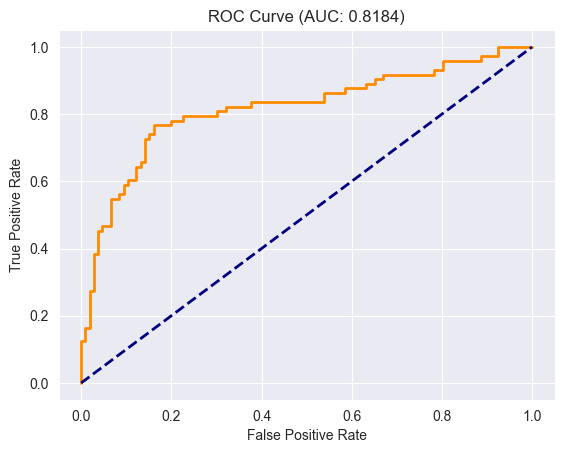

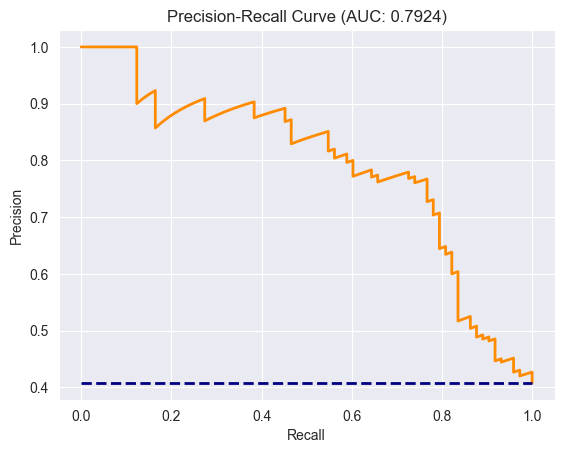

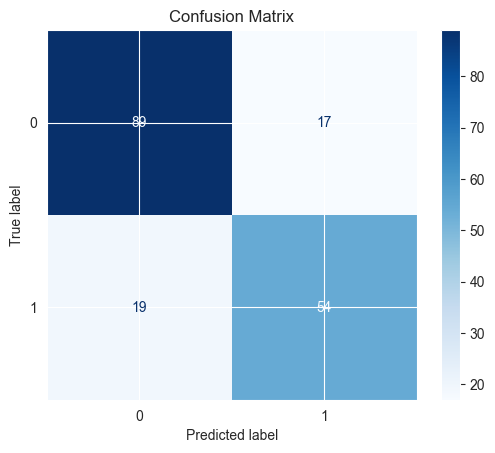

In [59]:
logistic_regressor_tester = ModelTester(LogisticRegression, processed_df, max_iter=1000)

logistic_regressor_tester.evaluate()

logistic_regressor_tester.plot_roc()
logistic_regressor_tester.plot_pr()
logistic_regressor_tester.plot_confusion_matrix()

El classification_report mostra diverses mètriques per cada classe i globalment:
- Precision: de totes les prediccions positives, quantes són correctes.
  Exemple: Sobreviu precision = 0.77 → del total de prediccions “Sobreviu”, el 77% són correctes.
- Recall (sensibilitat): de tots els positius reals, quants detectem.
  Exemple: Sobreviu recall = 0.74 → detectem el 74% dels supervivents reals.
- F1-score: mitjana harmònica de precision i recall, equilibra detectar positius sense generar massa falsos positius.
  Exemple: Sobreviu F1 = 0.76 → resumeix el rendiment sobre aquesta classe minoritària.
- Support: nombre de mostres reals d’aquesta classe. Exemple: 69 supervivents.
- Accuracy: proporció total de prediccions correctes (0.82).
- Macro avg: mitjana simple de les mètriques per classe.
- Weighted avg: mitjana ponderada pel nombre de mostres de cada classe.

En termes pràctics i morals, ens interessa prioritzar el recall de la classe positiva (Sobreviu),
ja que volem minimitzar falsos negatius i no deixar fora persones que realment sobreviuen.
És a dir, optem per prioritzar en detectar tots els supervivents i ajustem el threshold si cal (baixant-lo,
acceptant alguns FP per maximitzar la seguretat moral del nostre model abans que trobar-nos més FN.


Per optimitzar la classificació del nostre cas, ens fixem especialment en:
- Recall de la classe positiva → captar la majoria de supervivents.
- Average Precision / F1-score → equilibrar que no hi hagi massa falsos positius.

### 4. Model Selection amb validació creuada (4 punts)

Fent servir la mètrica trobada en l'apartat anterior, en aquest apartat caldrà seleccionar una sèrie de models i, fent ús de la validació creuada, seleccionar el millor model amb els seus respectius millors hyperpàrametres que haurem buscat fent hyperparameter search.

La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional **supervisat**. A sklearn, disposem de diverses tècniques [(veure documentació)](https://scikit-learn.org/stable/supervised_learning.html). A les classes de teoria, hem vist tècniques com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour... i també coneixeu altres tecniques d'altres cursos, com els arbres de decisio. Per aquest apartat es demana seleccionar **un minim de 3 models**.

**Preguntes:**
* Quins models heu considerat? Per què els heu seleccionat?
* Fent servir validació creuada, escolliu el millor model (agafant els hiperparàmetres per defecte). Recordeu fer servir la mètrica utilitzada en l'apartat anterior i fer fer servir algun [tipus de validacio creuada](https://scikit-learn.org/stable/modules/cross_validation.html).

* Seleccioneu una sèrie d'hiperparàmetres a provar per cadascun dels models i realitzeu una cerca d'hiperparàmetres. Hi ha algun model que creieu que podeu descartar de primeres? Per què?

* Mostreu els resultats en una taula on es mostri el model, els experiments realitzats i els resultats obtinguts (tant en train com en test). Podeu mostrar tambe el temps d'entrenament de cada model.

* Quin tipus de validació heu escollit en la selecció de models?

* Quines formes de buscar els millors hiperparàmetres heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html). Quina heu seleccionat?

* Si disposem de recursos limitats (per exemple, un PC durant 1 hora), quin dels mètodes creieu que obtindrà millor resultat final?

* Opcional: Feu la prova, i amb el model i el metode de validació creuada escollit, configureu els diferents mètodes de cerca per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (Ajuda: estimeu el temps que trigarà a fer 1 training el vostre model, i així trobeu el número de intents que podeu fer en cada cas.)

Llibreries que necessitem en aquesta secció.

In [60]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

Els models que provarem son els següents:

In [61]:
LOGISTIC_REGRESSION = "Logistic Regression"
KNN = "KNN"
GRADIENT_DESCENT = "Gradient Descent"
RANDOM_FOREST = "Random Forest"
EXTRA_TREES = "Extra Trees"
SUPPORT_VECTOR_MACHINE = "Support Vector Machine"
LINEAR_SVC = "LinearSVC"
GRADIENT_BOOSTING = "Gradient Boosting"
NAIVE_BAYES = "Naive Bayes"
PERCEPTRON = "Perceptron"
STOCHASTIC_GRADIENT_DESCENT = "Stochastic Gradient Descent"
NEURAL_NETWORK = "Neural Network"

Per cada tipus de model, tenim la classe i alguns paràmetres que deixarem per defecte en cada cas. Més endavant, quan farem optimització d'hiperparàmetres trobaren els valors òptims en cada cas.

In [62]:
models = {
    LOGISTIC_REGRESSION: {
        "model_class": LogisticRegression,
        "dataframe": processed_df,
        "max_iter": 10000,
    },
    KNN: {
        "model_class": KNeighborsClassifier,
        "dataframe": processed_df,
    },
    GRADIENT_DESCENT: {
        "model_class": SGDClassifier,
        "dataframe": processed_df,
        "max_iter": 10000,
        "tol": 1e-3
    },
    RANDOM_FOREST: {
        "model_class": RandomForestClassifier,
        "dataframe": processed_df,
        "n_estimators": 100
    },
    EXTRA_TREES: {
        "model_class": ExtraTreesClassifier,
        "dataframe": processed_df,
        "n_estimators": 100,
        "random_state": 1
    },
    SUPPORT_VECTOR_MACHINE: {
        "model_class": SVC,
        "dataframe": processed_df,
        "probability": True
    },
    LINEAR_SVC: {
        "model_class": LinearSVC,
        "dataframe": processed_df,
        "max_iter": 10000
    },
    GRADIENT_BOOSTING: {
        "model_class": GradientBoostingClassifier,
        "dataframe": processed_df,
        "n_estimators": 100
    },
    NAIVE_BAYES: {
        "model_class": GaussianNB,
        "dataframe": processed_df,
    },
    PERCEPTRON: {
        "model_class": Perceptron,
        "dataframe": processed_df,
        "max_iter": 10000
    },
    STOCHASTIC_GRADIENT_DESCENT: {
        "model_class": SGDClassifier,
        "dataframe": processed_df,
        "max_iter": 10000,
        "tol": 1e-3
    },
    NEURAL_NETWORK: {
        "model_class": MLPClassifier,
        "dataframe": processed_df,
        "hidden_layer_sizes": (50,),
        "max_iter": 1000
    }
}

Amb tot això, ja podem dur a terme un test bàsic evaluant cada model amb les mètriques triades.

Evaluating models: 12it [00:08,  1.42it/s]


,Model,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PR
0,Logistic Regression,0.798883,0.760563,0.739726,0.750000,0.818429,0.792377
1,KNN,0.581006,0.468750,0.205479,0.285714,0.569915,0.463924
2,Gradient Descent,0.458101,0.417808,0.835616,0.557078,0.516865,0.416167
3,Random Forest,0.770950,0.766667,0.630137,0.691729,0.845244,0.802224
4,Extra Trees,0.759777,0.767857,0.589041,0.666667,0.816425,0.762962
5,Support Vector Machine,0.692737,0.632353,0.589041,0.609929,0.766800,0.695758
6,LinearSVC,0.804469,0.763889,0.753425,0.758621,0.796524,0.676091
7,Gradient Boosting,0.776536,0.770492,0.643836,0.701493,0.832063,0.761140
8,Naive Bayes,0.709497,0.620690,0.739726,0.675000,0.744895,0.610219
9,Perceptron,0.592179,0.500000,0.013699,0.026667,0.502132,0.409084


,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PR
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.699721,0.653050,0.577626,0.582384,0.720783,0.640411
std,0.107040,0.129120,0.242799,0.217772,0.127543,0.151777
min,0.458101,0.417808,0.013699,0.026667,0.502132,0.409084
25%,0.655028,0.590517,0.558219,0.552729,0.624919,0.503478
50%,0.734637,0.683768,0.636986,0.670833,0.781662,0.685925
75%,0.776536,0.764583,0.739726,0.707626,0.816926,0.766803
max,0.804469,0.770492,0.835616,0.758621,0.845244,0.802224


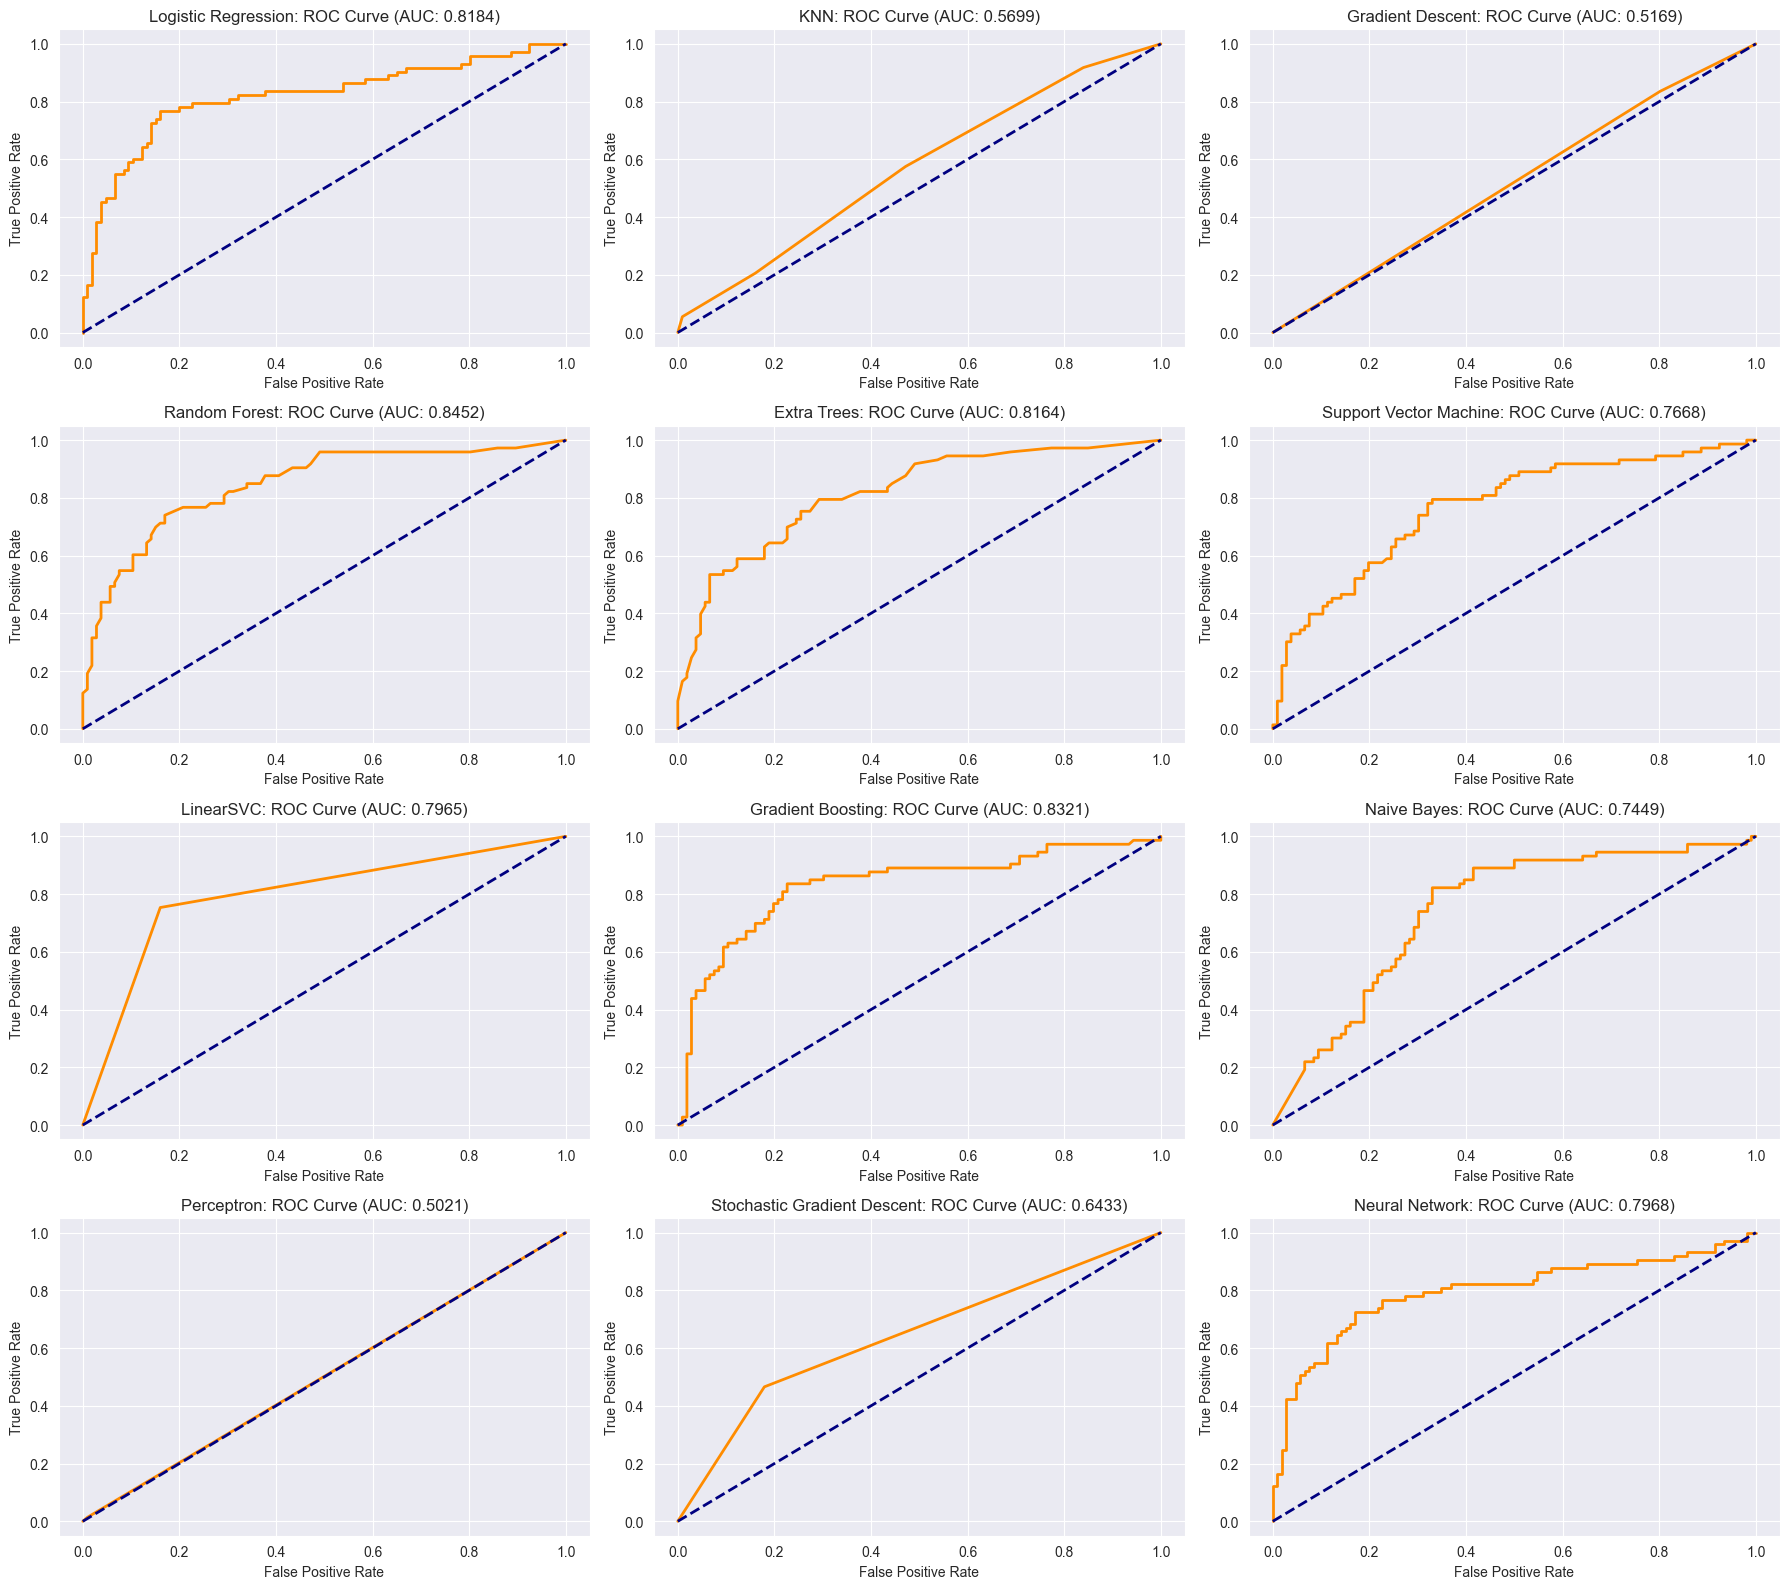

In [63]:
results_metrics = ["Model", "Accuracy", "Precision", "Recall", "F1", "AUC-ROC", "AUC-PR"]
results_df = pd.DataFrame(columns=results_metrics)

cols = 3
rows = (len(models)+cols-1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for ax, (model_name, settings) in tqdm(zip(axes, models.items()), desc="Evaluating models"):
    tester = ModelTester(name=model_name, **settings)
    metrics = tester.evaluate()

    tester.plot_roc(ax=ax)

    results_df.loc[len(results_df)] = [
        model_name,
        metrics["accuracy"],
        metrics["precision"],
        metrics["recall"],
        metrics["f1"],
        metrics["auc_roc"],
        metrics["auc_pr"]
    ]

display(results_df)
display(results_df.describe())

for ax in axes[len(models):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### 5. Anàlisi Final (1.5 punt)

Un cop seleccionat el millor model amb els millors hiperparàmetres, caldrà fer un anàlisi final amb els resultats obtinguts.

**Preguntes:**
* Mostreu les corves ROC/PR (la que hagueu escollit en l'apartat 2) i interpreteu els resultats.

* Analitzeu en detall les diferents mètriques que trobeu adients i comenteu per sobre com podrieu fer servir aquest model en un futur. Això és el que es coneix com un cas d'ús.

* Com creieu que es podria millorar el vostre model?